In [1]:
import torch
torch.manual_seed(1997)
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import os
import random

In [2]:
from google.colab import drive
#if you downloaded the file in the Colab directory in your Google Drive, use the following lines of code
drive.mount('/gdrive', force_remount=True)
data_file="/gdrive/My Drive/data" 

Mounted at /gdrive


In [3]:
!nvidia-smi

Mon Jun 28 02:18:06 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
class IDRiD_sub1_dataset(Dataset):

    def __init__(self, root_dir,transforms=None):
        """
            Args:
                root_dir:the root directory of the images
                Folders MA,HE,EX,SE
        """
        self.task_type_list = ['MA', 'HE','EX', 'SE']
        self.root_dir = root_dir
        self.data_idx = []
        self.data_cache = {'image': None, 'mask': None, 'name': "", 'index': None}#cache the original size image
        self.transforms=transforms  #if it is cero, only translation

        image_root = os.path.join(self.root_dir, 'images')
        
        i=0
        for filename in os.listdir(image_root):
            #If I only want to see with one example
            # i=i+1
            # if(i>1):
            #   break
            image_dir = os.path.join(image_root, filename)
            mask_dirs = {task_type:None for task_type in self.task_type_list}
            for task_type in self.task_type_list:
                m_dir = os.path.join(self.root_dir, task_type, filename[:-4]+'_'+task_type+'.tif')
                if os.path.isfile(m_dir): mask_dirs[task_type] = m_dir
            name = filename[:-4]
            self.data_idx.append((image_dir, mask_dirs, name))
        random.shuffle(self.data_idx)
        
    def __len__(self):
        return len(self.data_idx)*9*6
    

    def __getitem__(self, idx):
        # crop the 4288x2848 image into 512x512 => 9x6 grid
        # 1 image => 9x6 = 54 small images
        n = int(idx/(6*9))#image index
        r = int((idx%(6*9))/9)#row   until 5
        c = (idx%(6*9))%9#column until 8
        angle = random.choice([0,180])
        flip_hor = random.choice([0,1])
        flip_vert = random.choice([0,1])
        translation = random.choice([0,1,2])         
        #Load the images if it's not in the cache
        if self.data_cache['index'] != n:
            image_dir, mask_dirs, name = self.data_idx[n]
            image = Image.open(image_dir)

            # f=0
            masks_list=[]
            for task_type in self.task_type_list:
                if mask_dirs[task_type] is not None:
                    mask = Image.open(mask_dirs[task_type])
                    mask = np.array(mask, dtype='float32')
                    if (len(mask.shape)==3):
                      mask=mask[:,:,0]
                      mask[mask>=1]=1
                else:
                    w, h = image.size
                    mask = np.zeros((h, w), dtype='float32')

                
                masks_list.append(mask)
            masks = np.array(masks_list,dtype='float32')
            masks = np.pad(masks, ((0, 0), (37,37), (40, 40)), 'constant', constant_values=0)#padding
            self.data_cache = {'image': image, 'masks': masks, 'name': name, 'index': n}
                    
        
        #crop the image with transforms
        c_transl=0
        r_transl=0
        if self.transforms is not None:
          if (translation!=0):
            if (c==0 and r==0):
              c_transl=random.randint(0, 256)
              r_transl=random.randint(0, 256)
            elif (c==8 and r==5):
              c_transl=random.randint(-256, 0)
              r_transl=random.randint(-256, 0)
            elif (c==0 and r==5):
              c_transl=random.randint(0, 256)
              r_transl=random.randint(-256, 0)
            elif (c==8 and r==0):
              c_transl=random.randint(-256, 0)
              r_transl=random.randint(0, 256)
            elif (c==0):
              c_transl=random.randint(0, 256)
              r_transl=random.randint(-256, 256)
            elif (c==8):
              c_transl=random.randint(-256, 0)
              r_transl=random.randint(-256, 256)
            elif (r==0):
              r_transl=random.randint(0, 256)
              c_transl=random.randint(-256, 256)
            elif (r==5):
              r_transl=random.randint(-256, 0)
              c_transl=random.randint(-256, 256)
            else: 
              c_transl=random.randint(-256, 256)
              r_transl=random.randint(-256, 256)

        # print(f"translacion: en r {r_transl} y en c {c_transl}")
        image_crop = self.data_cache['image'].crop((c*482 - 40 + c_transl, r*482 - 37+r_transl, c*482 + 512 - 40 +c_transl, r*482 + 512 - 37 + r_transl))  #left,top,right,button - - rellena con ceros si falta una parte

        corners=[]
        corners.append(r*482+r_transl+15)
        corners.append(r*482 + 512+r_transl-15)
        corners.append(c*482+c_transl+15)
        corners.append(c*482 + 512+c_transl-15)
        masks_crop = self.data_cache['masks'][:, r*482+r_transl:r*482 + 512+r_transl, c*482+c_transl:c*482 + 512+c_transl]
        
        if self.transforms is not None and self.transforms!=0:
          i=0
          while (i<4):
            maskaux=Image.fromarray(masks_crop[i,:,:])
            if flip_hor:
              maskaux = self.transformation_hor(maskaux)
            if flip_vert:
              maskaux = self.transformation_vert(maskaux)
            if angle:
              maskaux = transforms.functional.rotate(maskaux, angle)
            masks_crop[i,:,:] = np.array(maskaux)
            i=i+1

        if self.transforms is not None and self.transforms!=0:
          if flip_hor:
            image_crop = self.transformation_hor(image_crop)
          if flip_vert:
            image_crop = self.transformation_vert(image_crop)
          if angle:
            image_crop = transforms.functional.rotate(image_crop, angle)

        image_crop = transforms.ToTensor()(image_crop)
        masks_crop = torch.from_numpy(masks_crop)

        name = self.data_cache['name']+'(%2d, %2d)'%(r, c)
        if (self.transforms==0):
          return image_crop, masks_crop, name,corners
        return image_crop, masks_crop, name
    
    transformation_hor = transforms.RandomChoice([                                  
    transforms.RandomHorizontalFlip(p=1)
    ])
    transformation_vert = transforms.RandomChoice([                                  
    transforms.RandomVerticalFlip(p=1)
    ])

        

In [5]:
#Just to see the uploading of the images
'''
import torch
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader
import torchvision
import time
import copy
import os
import matplotlib.pyplot as plt

torch.manual_seed(1997)

data_train_dir = '/gdrive/My Drive/data/training'
dataset_train = IDRiD_sub1_dataset(data_train_dir, transforms=1)

dataloader_train = DataLoader(dataset_train, batch_size=6, shuffle=False, num_workers=2)

def show_img(img):
    plt.figure(figsize=(18,15))
    # unnormalize
    img = img / 2 + 0.5  
    npimg = img.numpy()
    npimg = np.clip(npimg, 0., 1.)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

data = iter(dataloader_train)
# print(data)
images = data.next()
images = data.next()
images = data.next()


# print(images[1].shape)
#print(images[0])
# show images
show_img(torchvision.utils.make_grid(images[0]))


i=0
while (i<1):
  j=0
  print(f"imagen: {i}")
  while (j<4):
    print(f"imagen: {i} lession: {j}")
    plt.figure(figsize=(18,15))
    plt.imshow(images[1][i,j,:,:])
    plt.show()
    j=j+1
  i=i+1
'''

'\nimport torch\nimport torch.optim as optim\nfrom torch.optim.lr_scheduler import ReduceLROnPlateau\nimport torch.nn.functional as F\nfrom torch.autograd import Variable\nfrom torch.utils.data import DataLoader\nimport torchvision\nimport time\nimport copy\nimport os\nimport matplotlib.pyplot as plt\n\ntorch.manual_seed(1997)\n\ndata_train_dir = \'/gdrive/My Drive/data/training\'\ndataset_train = IDRiD_sub1_dataset(data_train_dir, transforms=1)\n\ndataloader_train = DataLoader(dataset_train, batch_size=6, shuffle=False, num_workers=2)\n\ndef show_img(img):\n    plt.figure(figsize=(18,15))\n    # unnormalize\n    img = img / 2 + 0.5  \n    npimg = img.numpy()\n    npimg = np.clip(npimg, 0., 1.)\n    plt.imshow(np.transpose(npimg, (1, 2, 0)))\n    plt.show()\n\ndata = iter(dataloader_train)\n# print(data)\nimages = data.next()\nimages = data.next()\nimages = data.next()\n\n\n# print(images[1].shape)\n#print(images[0])\n# show images\nshow_img(torchvision.utils.make_grid(images[0]))\n\n\

In [6]:
# if __name__ == '__main__':
#     dataset = IDRiD_sub1_dataset('/gdrive/My Drive/data/training')
#     #print(dataset)
#     print('dataset length: %d'%(len(dataset)))
#     #data formate test
    
#     print('dataset sample')
#     # val=random.randint(0, len(dataset)-1)
#     # print(val)
#     # image, mask, name = dataset[val]
#     #print(image, mask, name)
    
#     #show image test

#     import matplotlib.pyplot as plt
#     # for i in range(len(dataset)):
#     for i in range(5):
#         image, mask, name = dataset[i]
#         #print(image, mask, name)
#         plt.imshow(transforms.ToPILImage()(image))
#         plt.show()
#         plt.imshow(mask.numpy()[2])
#         plt.show()

#     # for i in range(len(dataset)):
#     for i in range(5):
#         image, mask, name = dataset[i]
#         #print(image, mask, name)
#         plt.imshow(transforms.ToPILImage()(image))
#         plt.show()
#         plt.imshow(mask.numpy()[2])
#         plt.show()


    # dataloader test
    # from torch.utils.data import DataLoader
    # import time
    # t = time.time()
    # dataloader = DataLoader(dataset, batch_size=100, shuffle=False, num_workers=2)
    # for data in dataloader:
    #     pass
    #print('%ds'%(time.time()-t))
    

In [7]:
'''
The code is modified from https://github.com/ZijunDeng/pytorch-semantic-segmentation
'''
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

In [8]:
# many are borrowed from https://github.com/ycszen/pytorch-ss/blob/master/gcn.py
class _GlobalConvModule(nn.Module):
    def __init__(self, in_dim, out_dim, kernel_size):
        super(_GlobalConvModule, self).__init__()
        pad0 = int((kernel_size[0] - 1) / 2)
        pad1 = int((kernel_size[1] - 1) / 2)
        # kernel size had better be odd number so as to avoid alignment error
        super(_GlobalConvModule, self).__init__()
        self.conv_l1 = nn.Conv2d(in_dim, out_dim, kernel_size=(kernel_size[0], 1),
                                 padding=(pad0, 0))
        self.conv_l2 = nn.Conv2d(out_dim, out_dim, kernel_size=(1, kernel_size[1]),
                                 padding=(0, pad1))
        self.conv_r1 = nn.Conv2d(in_dim, out_dim, kernel_size=(1, kernel_size[1]),
                                 padding=(0, pad1))
        self.conv_r2 = nn.Conv2d(out_dim, out_dim, kernel_size=(kernel_size[0], 1),
                                 padding=(pad0, 0))

    def forward(self, x):
        x_l = self.conv_l1(x)
        x_l = self.conv_l2(x_l)
        x_r = self.conv_r1(x)
        x_r = self.conv_r2(x_r)
        x = x_l + x_r
        return x


class _BoundaryRefineModule(nn.Module):
    def __init__(self, dim):
        super(_BoundaryRefineModule, self).__init__()
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(dim, dim, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(dim, dim, kernel_size=3, padding=1)

    def forward(self, x):
        residual = self.conv1(x)
        residual = self.relu(residual)
        residual = self.conv2(residual)
        out = x + residual
        return out


class GCN(nn.Module):
    def __init__(self, num_classes, input_size):
        super(GCN, self).__init__()
        self.input_size = input_size
        resnet = models.resnet152(pretrained=True)
        
        self.layer0 = nn.Sequential(resnet.conv1, resnet.bn1, resnet.relu)
        self.layer1 = nn.Sequential(resnet.maxpool, resnet.layer1)
        self.layer2 = resnet.layer2
        self.layer3 = resnet.layer3
        self.layer4 = resnet.layer4

        self.gcm1 = _GlobalConvModule(2048, num_classes, (7, 7))
        self.gcm2 = _GlobalConvModule(1024, num_classes, (7, 7))
        self.gcm3 = _GlobalConvModule(512, num_classes, (7, 7))
        self.gcm4 = _GlobalConvModule(256, num_classes, (7, 7))

        self.brm1 = _BoundaryRefineModule(num_classes)
        self.brm2 = _BoundaryRefineModule(num_classes)
        self.brm3 = _BoundaryRefineModule(num_classes)
        self.brm4 = _BoundaryRefineModule(num_classes)
        self.brm5 = _BoundaryRefineModule(num_classes)
        self.brm6 = _BoundaryRefineModule(num_classes)
        self.brm7 = _BoundaryRefineModule(num_classes)
        self.brm8 = _BoundaryRefineModule(num_classes)
        self.brm9 = _BoundaryRefineModule(num_classes)

        initialize_weights(self.gcm1, self.gcm2, self.gcm3, self.gcm4, self.brm1, self.brm2, self.brm3,
                           self.brm4, self.brm5, self.brm6, self.brm7, self.brm8, self.brm9)

    def forward(self, x):
        # if x: 512
        fm0 = self.layer0(x)  # 256
        fm1 = self.layer1(fm0)  # 128
        fm2 = self.layer2(fm1)  # 64
        fm3 = self.layer3(fm2)  # 32
        fm4 = self.layer4(fm3)  # 16

        gcfm1 = self.brm1(self.gcm1(fm4))  # 16
        gcfm2 = self.brm2(self.gcm2(fm3))  # 32
        gcfm3 = self.brm3(self.gcm3(fm2))  # 64
        gcfm4 = self.brm4(self.gcm4(fm1))  # 128

        fs1 = self.brm5(F.upsample(gcfm1, fm3.size()[2:], mode='bilinear') + gcfm2)  # 32
        fs2 = self.brm6(F.upsample(fs1, fm2.size()[2:], mode='bilinear') + gcfm3)  # 64
        fs3 = self.brm7(F.upsample(fs2, fm1.size()[2:], mode='bilinear') + gcfm4)  # 128
        fs4 = self.brm8(F.upsample(fs3, fm0.size()[2:], mode='bilinear'))  # 256
        out = self.brm9(F.upsample(fs4, self.input_size, mode='bilinear'))  # 512

        return out
    
    
def initialize_weights(*models):
    for model in models:
        for module in model.modules():
            if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
                nn.init.kaiming_normal(module.weight)
                if module.bias is not None:
                    module.bias.data.zero_()
            elif isinstance(module, nn.BatchNorm2d):
                module.weight.data.fill_(1)
                module.bias.data.zero_()

In [9]:
import torch
from sklearn.metrics import f1_score
import numpy as np
import os

def weighted_BCELoss(output, target, weights=None):

    output = output.clamp(min=1e-5, max=1-1e-5)
    if weights is not None:
        assert len(weights) == 2

        loss = -weights[0] * (target * torch.log(output)) - weights[1] * ((1 - target) * torch.log(1 - output))
    else:
        loss = -target * torch.log(output) - (1 - target) * torch.log(1 - output)

    return torch.mean(loss)

def evaluate(y_true, y_pred):
    '''
    Calculate statistic matrix.
    
    Args:
        y_true:the pytorch tensor of ground truth
        y_pred:the pytorch tensor of prediction
    return:
        The F1 score
    '''
    y_true = y_true.numpy().flatten()
    y_pred = np.rint(y_pred.numpy().flatten())
    f1 = f1_score(y_true, y_pred)
    return f1


def save_model(model, save_dir, name):
    #save model
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    path = os.path.join(save_dir, name)
    print('Saving model to directory "%s"'%(path))
    torch.save(model.state_dict(), path)

In [10]:
#Train the model

import torch
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader
import time
import copy
import os

In [11]:
use_gpu = torch.cuda.is_available()
save_dir = "/gdrive/My Drive/data/saved_models"
model_name = "test.pth"
model_name_train = "train.pth"
data_train_dir = '/gdrive/My Drive/data/training'
data_val_dir = '/gdrive/My Drive/data/test'
batch_size = 8
num_epochs = 10
lr = 1e-4

In [15]:
def make_dataloaders(batch_size=batch_size):
    dataset_train = IDRiD_sub1_dataset(data_train_dir,transforms=1)
    #dataset_train = IDRiD_sub1_dataset(data_train_dir)
    dataset_val = IDRiD_sub1_dataset(data_val_dir)
    dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=2)
    dataloader_val = DataLoader(dataset_val, batch_size=batch_size, shuffle=False, num_workers=2)
    dataloaders = {'train': dataloader_train, 'val': dataloader_val}
    print('Training data: %d\nValidation data: %d'%((len(dataset_train)), len(dataset_val)))
    return dataloaders

def train_model(model, num_epochs, dataloaders, optimizer, scheduler):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_f1 = 0.0
    best_epoch_loss=1000000
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode
        
            running_loss = 0.0
            running_f1 = 0.0
            data_num = 0
            
            for idx, data in enumerate(dataloaders[phase]):
                images, masks, names = data
                
                
                #print(names)
                #weight for loss
                weights = [5, 1]
                if use_gpu:
                    weights = torch.FloatTensor(weights).cuda()

                #print(use_gpu)
                if use_gpu:
                    images = images.cuda()
                    masks = masks.cuda()              
                
                #forward

                if phase == "train":
                  outputs = model(images)
                  outputs = F.sigmoid(outputs)#remenber to apply sigmoid befor usage
                  loss = weighted_BCELoss(outputs, masks, weights)
                  
                  #backword
                  
                  optimizer.zero_grad()
                  loss.backward()
                  optimizer.step()
                  
                  # statistics
                  running_loss += loss.data*images.size(0)
                  data_num += images.size(0)
                  outputs = outputs.cpu().data
                  #print(outputs.shape)
                  masks = masks.cpu().data

                  running_f1 += evaluate(masks, outputs)*images.size(0)
                  
                  #verbose
                  if idx%15==0 and idx!=0:
                    print(names)
                    


                elif phase == "val":
                  with torch.no_grad():
                    outputs = model(images)
                    outputs = F.sigmoid(outputs)#remenber to apply sigmoid befor usage
                    loss = weighted_BCELoss(outputs, masks, weights)
                    
                    #backword
                                        
                    # statistics
                    running_loss += loss.data*images.size(0)
                    data_num += images.size(0)
                    outputs = outputs.cpu().data
                    #print(outputs.shape)
                    masks = masks.cpu().data
                    #print(masks.shape)
                    running_f1 += evaluate(masks, outputs)*images.size(0)
                    
                    #verbose
                    if idx%15==0 and idx!=0:
                      print(names)
                      
                    
            epoch_loss = running_loss / data_num
            epoch_f1 = running_f1 / data_num
            if phase == 'val':
                scheduler.step(epoch_loss)
            print('{} Loss: {:.4f} F1 score: {:.4f}'.format(phase, epoch_loss, epoch_f1))
            # deep copy the model
            if phase == 'val' and epoch_f1 > best_f1:
                best_f1 = epoch_f1
                best_model_wts = copy.deepcopy(model.state_dict())
                save_model(model, save_dir, model_name)
            if phase == 'train' and epoch_loss < best_epoch_loss:
                best_epoch_loss = epoch_loss
                save_model(model, save_dir, model_name_train)
                
        print()
    
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    
    print('Best F1 score: {:.4f}'.format(best_f1))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
if __name__ == '__main__':
    # dataset
    dataloaders = make_dataloaders(batch_size=batch_size)
    
    #model
    model = GCN(4, 512)
    if use_gpu:
        model = model.cuda()
        #model = torch.nn.DataParallel(model).cuda()
    # Comment next line, if pretrained network not use
    model.load_state_dict(torch.load(os.path.join(save_dir, '4_train5_14epochswhole.pth'))) 
    #training
    optimizer = optim.Adam(model.parameters(), lr = lr)
    scheduler = ReduceLROnPlateau(optimizer, 'min', verbose=True)
    model = train_model(model, num_epochs, dataloaders, optimizer, scheduler)
    
    #save
    #save_model(model, save_dir, model_name)

In [17]:
# Testing*
import torch
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import numpy as np
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix,precision_recall_curve,auc,average_precision_score,plot_precision_recall_curve
from PIL import Image
import matplotlib.pyplot as plt
import os

use_gpu = torch.cuda.is_available
save_dir = "/gdrive/My Drive/data/saved_models"
save_model_name = "4_train5_14epochswhole.pth"
data_dir = '/gdrive/My Drive/data/test'
results_dir = '/gdrive/My Drive/data/test_results'
batch_size = 8

In [18]:
def plot_aucpr(y_true,y_pred,str='!'):
    precision, recall, th= precision_recall_curve(y_true.flatten(),y_pred.flatten())
    plt.figure()
    plt.plot(recall,precision)
    plt.title(f'{str}')
    plt.show()


def show_image_sample():
    # dataset
    dataset = IDRiD_sub1_dataset(data_dir)

    
    #model
    model = GCN(4, 512)
    if use_gpu:
        model = model.cuda()
        #model = torch.nn.DataParallel(model).cuda()
    model.load_state_dict(torch.load(os.path.join(save_dir, save_model_name))) 
    model.train(False)
    for n in range(5):
        #test
        full_image = np.zeros((3, 2848, 4288), dtype='float32')
        full_mask = np.zeros((4, 2848, 4288), dtype='float32')
        full_output = np.zeros((4, 2848, 4288), dtype='float32')#(C, H, W)
        title = ''
        for idx in range(9*6*n, 9*6*(n+1)):
            # print(idx)
            image, mask, name = dataset[idx]
            n = int(idx/(6*9))#image index
            r = int((idx%(6*9))/9)#row
            c = (idx%(6*9))%9#column
            # print(c)
            title = name[:-8]
            
            if use_gpu:
                image = image.cuda()
                mask = mask.cuda()
            with torch.no_grad():
                #forward
                output = model(image.unsqueeze(0))
                output = F.sigmoid(output)
                output = output[0]
            
            output=output[:,15:497,15:497]
            mask=mask[:,15:497,15:497]
            image=image[:,15:497,15:497]
            # print(mask.shape)
                
                     
            if c==0 and r==0:
                full_output[:, 0:482 - 22, 0 : 482 - 25] = output.cpu().data.numpy()[:, 22: ,25:]
                full_mask[:, 0:482 - 22, 0 : 482 - 25] = mask.cpu().data.numpy()[:, 22: ,25:]
                full_image[:, 0:482 - 22, 0 : 482 - 25] = image.cpu().data.numpy()[:, 22: ,25:]
            
            elif c==0 and r!=0 and r!=5:
                full_output[:, r*482 - 22 : r*482 + 482 - 22, 0 : 482 - 25] = output.cpu().data.numpy()[:, : ,25:]
                full_mask[:, r*482 - 22 : r*482 + 482 - 22, 0 : 482 - 25] = mask.cpu().data.numpy()[:, : ,25:]
                full_image[:, r*482 - 22 : r*482 + 482 - 22, 0 : 482 - 25] = image.cpu().data.numpy()[:, : ,25:]

            elif c==0 and r==5:
                full_output[:, r*482 - 22 : r*482 + 482 - 22 - 22, 0 : 482 - 25] = output.cpu().data.numpy()[:, :482-22 ,25:]
                full_mask[:, r*482 - 22 : r*482 + 482 - 22 - 22, 0 : 482 - 25] = mask.cpu().data.numpy()[:, :482-22 ,25:]
                full_image[:, r*482 - 22 : r*482 + 482 - 22 - 22, 0 : 482 - 25]= image.cpu().data.numpy()[:, :482-22 ,25:]

            elif r==0 and c!=0 and c!=8:
                full_output[:, 0 : 482-22, c*482-25:c*482+482-25] = output.cpu().data.numpy()[:, 22: , :]
                full_mask[:, 0 : 482-22, c*482-25:c*482+482-25]= mask.cpu().data.numpy()[:, 22: , :]
                full_image[:, 0 : 482-22, c*482-25:c*482+482-25]= image.cpu().data.numpy()[:, 22: , :]

            elif r==0 and c==8:
                full_output[:, 0 : 482-22, c*482-25:c*482+482-25-25] = output.cpu().data.numpy()[:, 22: , :482-25]
                full_mask[:, 0 : 482-22, c*482-25:c*482+482-25-25] = mask.cpu().data.numpy()[:, 22: , :482-25]
                full_image[:, 0 : 482-22, c*482-25:c*482+482-25-25] = image.cpu().data.numpy()[:, 22: , :482-25]

            elif c==8 and r!=0 and r!=5:
                full_output[:, r*482 - 22 : r*482 + 482 - 22 , c*482-25:c*482+482-25-25] = output.cpu().data.numpy()[:, : , :482-25]
                full_mask[:, r*482 - 22 : r*482 + 482 - 22 , c*482-25:c*482+482-25-25]  = mask.cpu().data.numpy()[:, : , :482-25]
                full_image[:, r*482 - 22 : r*482 + 482 - 22 , c*482-25:c*482+482-25-25]  = image.cpu().data.numpy()[:, : , :482-25]

            elif c==8 and r==5:
                full_output[:, r*482 - 22 : r*482 + 482 - 22 - 22 , c*482-25:c*482+482-25-25] = output.cpu().data.numpy()[:, : 482 - 22 , :482-25]
                full_mask[:, r*482 - 22 : r*482 + 482 - 22 - 22 , c*482-25:c*482+482-25-25]  = mask.cpu().data.numpy()[:, : 482 - 22 , :482-25]
                full_image[:, r*482 - 22 : r*482 + 482 - 22 - 22 , c*482-25:c*482+482-25-25]  = image.cpu().data.numpy()[:, : 482 - 22 , :482-25]

            elif r==5 and c!=0 and c!=8:
                full_output[:, r*482 - 22 : r*482 + 482 - 22 - 22 , c*482-25:c*482+482 - 25] = output.cpu().data.numpy()[:, : 482 - 22 , :]
                full_mask[:, r*482 - 22 : r*482 + 482 - 22 - 22 , c*482-25:c*482+482 - 25] = mask.cpu().data.numpy()[:, : 482 - 22 , :]
                full_image[:, r*482 - 22 : r*482 + 482 - 22 - 22 , c*482-25:c*482+482 - 25]  = image.cpu().data.numpy()[:, : 482 - 22 , :]
            
            else:
                full_output[:, r*482 - 22 : r*482 + 482 - 22 , c*482-25:c*482+482 - 25] = output.cpu().data.numpy()[:, : , :]
                full_mask[:, r*482 - 22 : r*482 + 482 - 22 , c*482-25:c*482+482 - 25]= mask.cpu().data.numpy()[:, : , :]
                full_image[:, r*482 - 22 : r*482 + 482 - 22 , c*482-25:c*482+482 - 25] = image.cpu().data.numpy()[:, :, :]

            
        full_image = full_image.transpose(1, 2, 0)
        MA = full_output[0]
        plot_aucpr(full_mask[0],MA,'MA')
        HE = full_output[1]
        plot_aucpr(full_mask[1],HE,'HE')
        EX = full_output[2]
        plot_aucpr(full_mask[2],EX,'EX')
        SE = full_output[3]
        plot_aucpr(full_mask[3],SE,'SE')
        
        auc_MA=1
        auc_HE=1
        auc_EX=1
        auc_SE=1

        plt.figure()
        fig = plt.figure(figsize=(18, 18)) 
        plt.axis('off')
        plt.suptitle(title)
        plt.subplot(331)
        plt.title('image')
        fig = plt.imshow(full_image)
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)
        plt.subplot(332)
        plt.title('ground truth MA')
        fig = plt.imshow(full_mask[0])
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)
        plt.subplot(333)
        plt.title('ground truth HE')
        fig = plt.imshow(full_mask[1])
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)
        plt.subplot(334)
        plt.title('ground truth EX')
        fig = plt.imshow(full_mask[2])
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)
        plt.subplot(335)
        plt.title('ground truth SE')
        fig = plt.imshow(full_mask[3])
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)
        plt.subplot(336)
        plt.title(f'predict MA - auc={auc_MA}')
        fig = plt.imshow(MA)
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)
        plt.subplot(337)
        plt.title(f'predict HE - auc={auc_HE}')
        fig = plt.imshow(HE)
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)
        plt.subplot(338)
        plt.title(f'predict EX - auc={auc_EX}')
        fig = plt.imshow(EX)
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)
        plt.subplot(339)
        plt.title(f'predict SE - auc={auc_SE}')
        fig = plt.imshow(SE)
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)
        plt.show()
        


In [ ]:
#run test and see results
if __name__ == '__main__':
    show_image_sample()
    

In [ ]:
#similar as before but averaging with random translation of basic patches
#improve performance but needs more time

def show_image_sample():
    # dataset
    dataset = IDRiD_sub1_dataset(data_dir,transforms=0)
    print(len(dataset))
    
    #model
    model = GCN(4, 512)
    if use_gpu:
        model = model.cuda()
        #model = torch.nn.DataParallel(model).cuda()
    model.load_state_dict(torch.load(os.path.join(save_dir, save_model_name))) 
    model.train(False)
    for n in range(round(len(dataset)/54)):
        #test
        full_image = np.zeros((3, 37*2+2848, 40*2+4288), dtype='float32')
        # mask_full_image = np.zeros((3, 37*2+2848, 40*2+4288), dtype='int32')
        full_mask = np.zeros((4, 37*2+2848, 40*2+4288), dtype='float32')
        full_mask_patches_counter = np.zeros((37*2+2848, 40*2+4288), dtype='int32')
        full_output = np.zeros((4, 37*2+2848, 40*2+4288), dtype='float32')#(C, H, W)
        #mask_full_output = np.zeros((4, 37*2+2848, 40*2+4288), dtype='int32')
        title = ''
        for pp in range(10): #in average 10 times in each pixel
          for idx in range(9*6*n, 9*6*(n+1)):
              # print(idx)
              image, mask, name, corners = dataset[idx]
              title = name[:-8]
              #mask_patch=np.int32(mask_patch)
              if use_gpu:
                  image = image.cuda()
                  mask = mask.cuda()
              with torch.no_grad():
                  #forward
                  output = model(image.unsqueeze(0))
                  output = F.sigmoid(output)
                  output = output[0]
              
              output=np.array(output.cpu())
              output=output[:,15:497,15:497]
              mask=np.array(mask.cpu())
              mask=mask[:,15:497,15:497]
              image=np.array(image.cpu())
              image=image[:,15:497,15:497]


              full_mask_patches_counter[corners[0]:corners[1],corners[2]:corners[3]]+=1
              full_image[:,corners[0]:corners[1],corners[2]:corners[3]]=image
              full_mask[:,corners[0]:corners[1],corners[2]:corners[3]]=mask
              full_output[:,corners[0]:corners[1],corners[2]:corners[3]]+=output


        full_mask_patches_counter[full_mask_patches_counter==0]=1
        full_output=np.divide(full_output,full_mask_patches_counter)  

        full_image=full_image[:,37:37+2848,40:40+4288]
        full_mask=full_mask[:,37:37+2848,40:40+4288]
        full_output=full_output[:,37:37+2848,40:40+4288]
            
        full_image = full_image.transpose(1, 2, 0)
        MA = full_output[0]
        plot_aucpr(full_mask[0],MA,'MA')
        HE = full_output[1]
        plot_aucpr(full_mask[1],HE,'HE')
        EX = full_output[2]
        plot_aucpr(full_mask[2],EX,'EX')
        SE = full_output[3]
        plot_aucpr(full_mask[3],SE,'SE')

        print(title)
        plt.figure()
        fig = plt.figure(figsize=(18, 18)) 
        plt.axis('off')
        plt.suptitle(title)
        plt.subplot(331)
        plt.title(f'Image {title}')
        fig = plt.imshow(full_image)
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)
        plt.subplot(332)
        plt.title('ground truth MA')
        fig = plt.imshow(full_mask[0])
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)
        plt.subplot(333)
        plt.title(f'predict MA')
        fig = plt.imshow(MA)
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)
        plt.subplot(334)
        plt.title('ground truth HE')
        fig = plt.imshow(full_mask[1])
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)
        plt.subplot(335)
        plt.title(f'predict HE')
        fig = plt.imshow(HE)
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)
        plt.subplot(336)
        plt.title('ground truth EX')
        fig = plt.imshow(full_mask[2])
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)
        plt.subplot(337)
        plt.title(f'predict EX')
        fig = plt.imshow(EX)
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)
        plt.subplot(338)
        plt.title('ground truth SE')
        fig = plt.imshow(full_mask[3])
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)
        plt.subplot(339)
        plt.title(f'predict SE')
        fig = plt.imshow(SE)
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)
        plt.savefig(f"{results_dir}/{title}.png")
        plt.show()
        

if __name__ == '__main__':
    show_image_sample()

1458


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3487: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


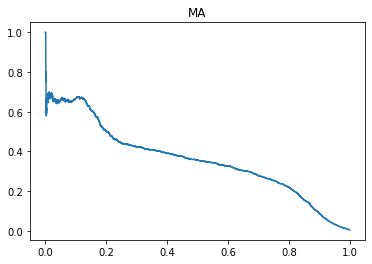

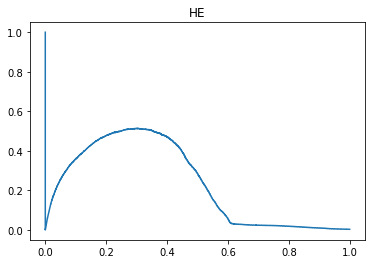

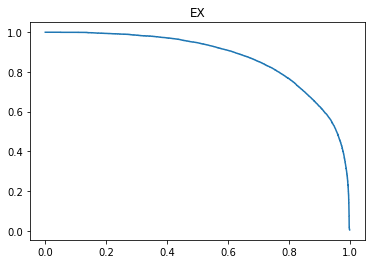

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:677: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


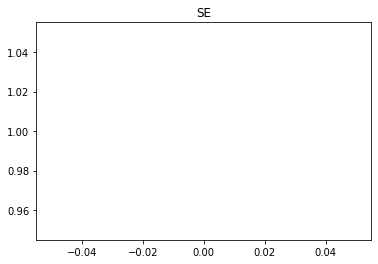

IDRiD_62


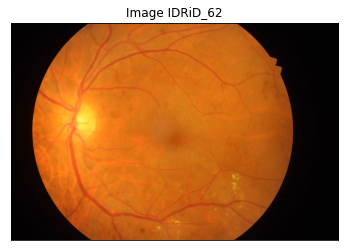

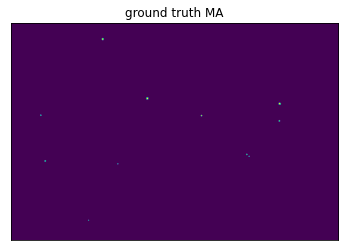

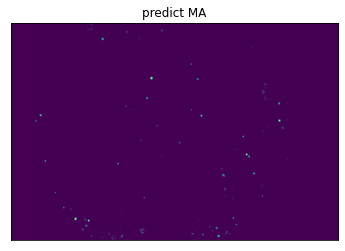

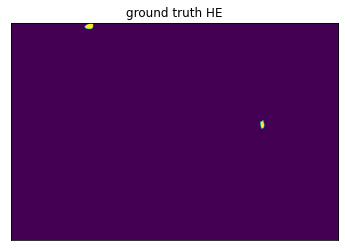

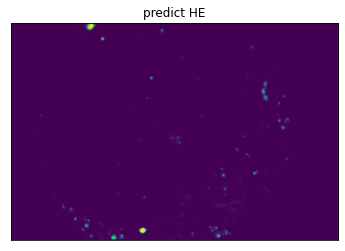

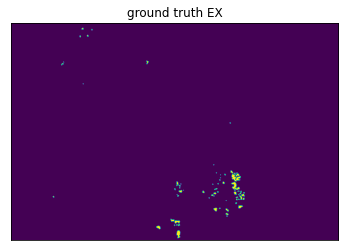

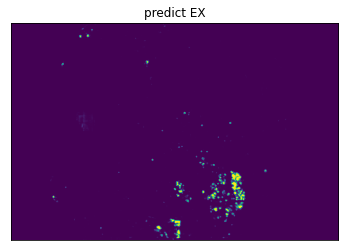

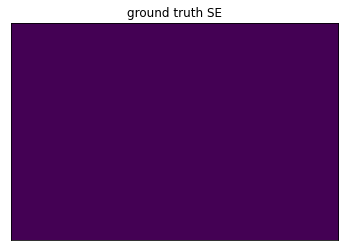

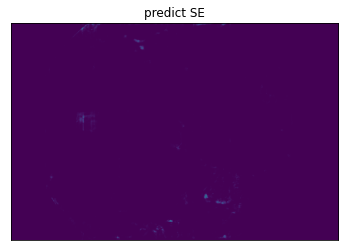

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3487: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


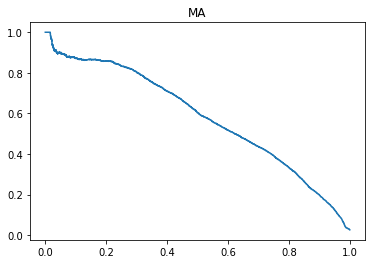

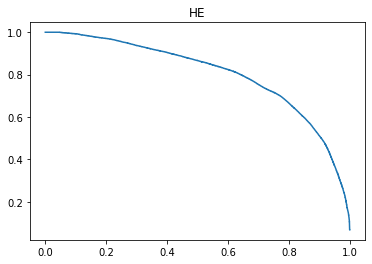

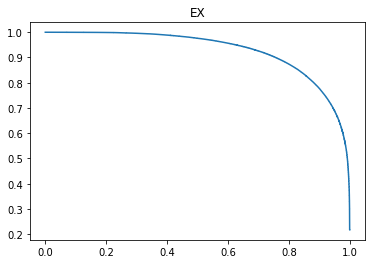

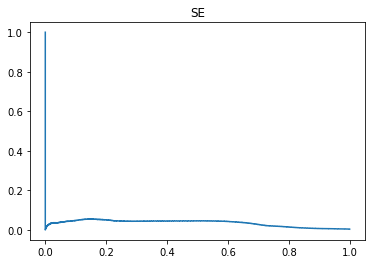

IDRiD_55


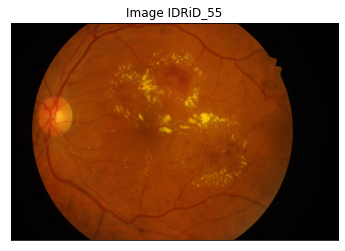

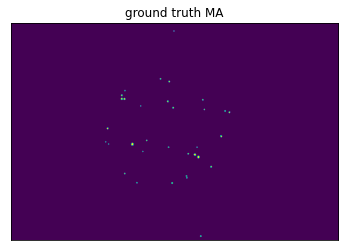

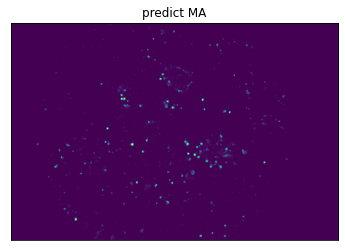

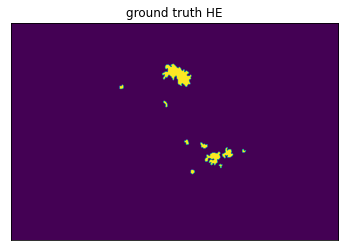

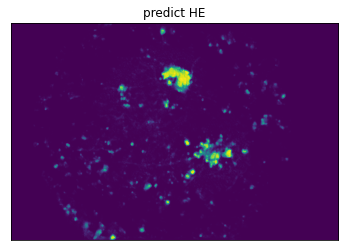

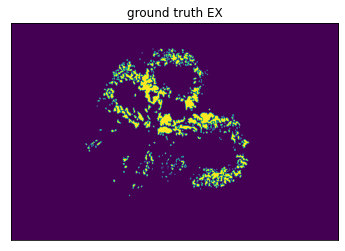

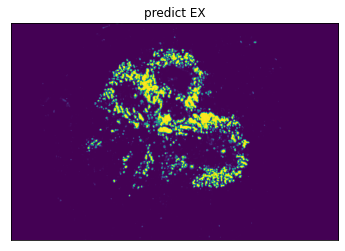

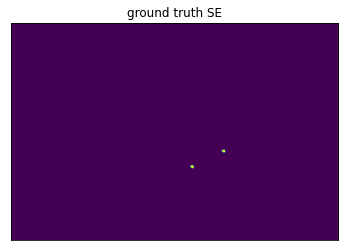

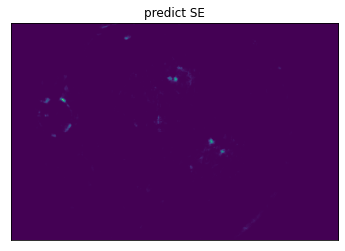

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3487: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


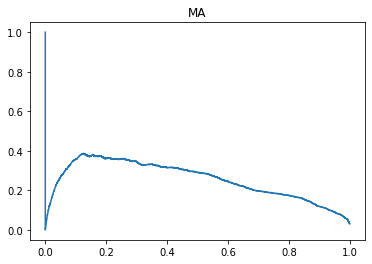

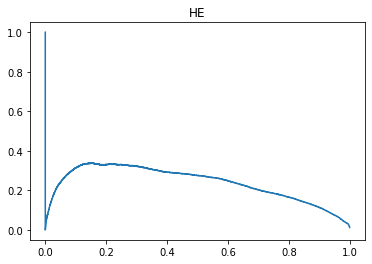

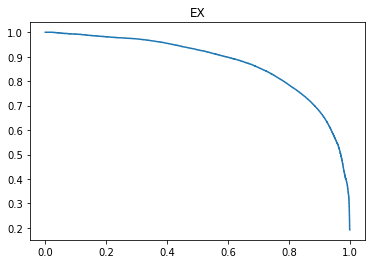

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:677: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


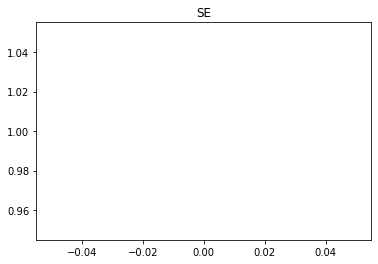

IDRiD_63


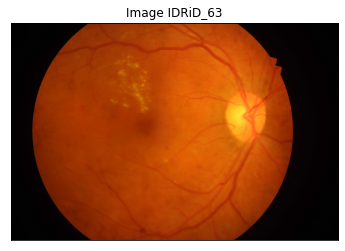

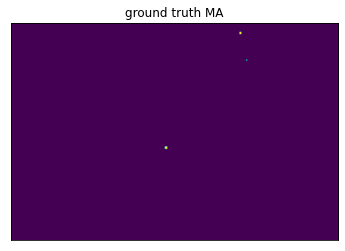

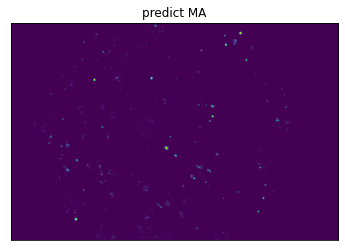

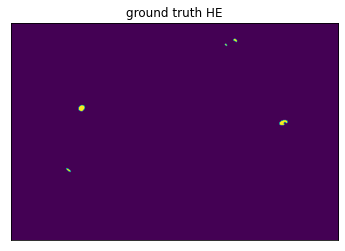

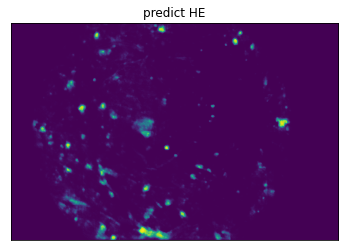

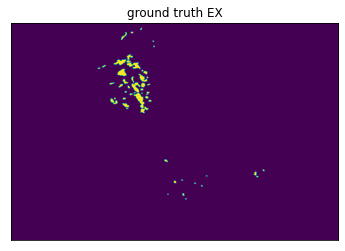

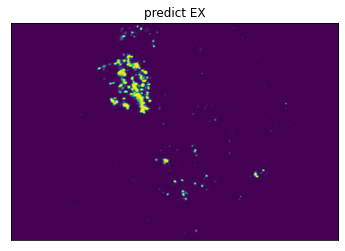

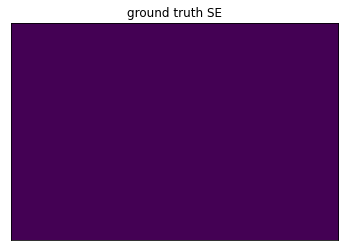

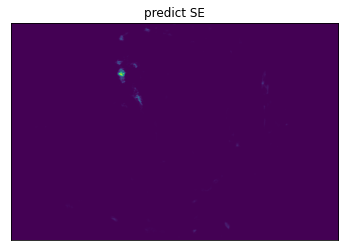

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3487: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


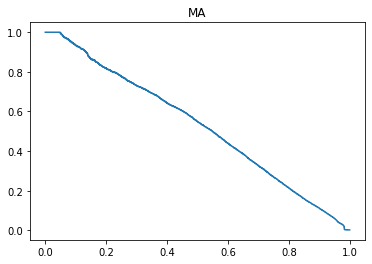

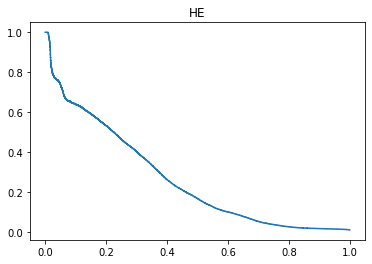

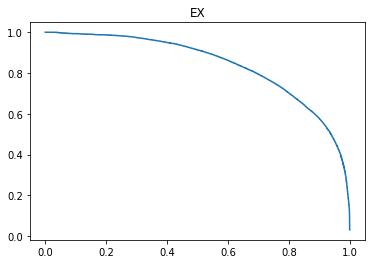

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:677: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


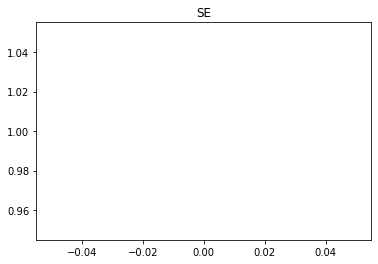

IDRiD_78


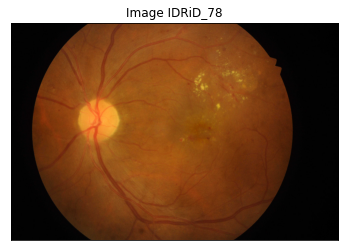

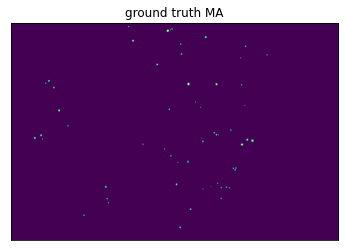

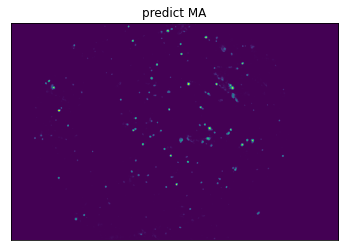

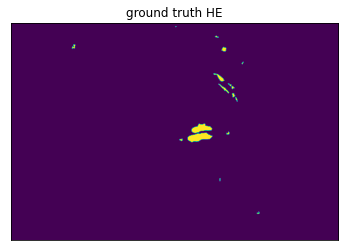

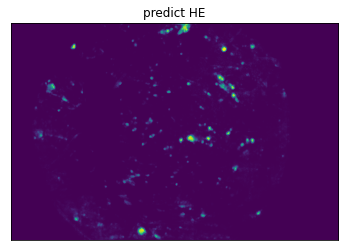

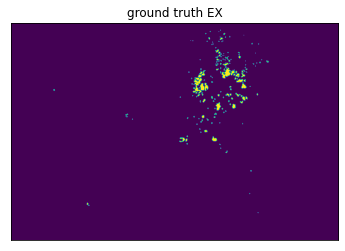

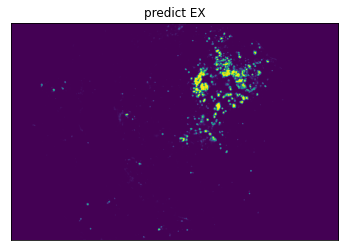

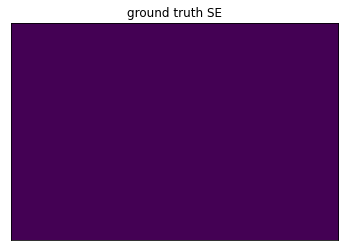

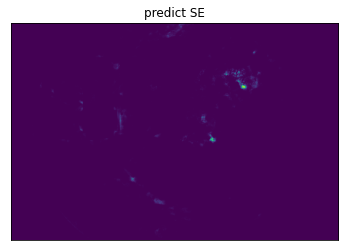

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3487: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


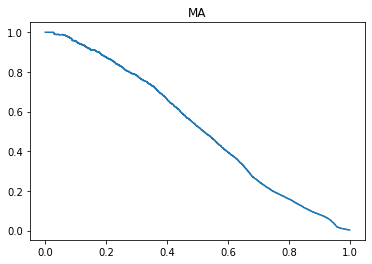

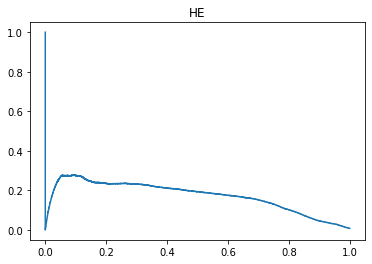

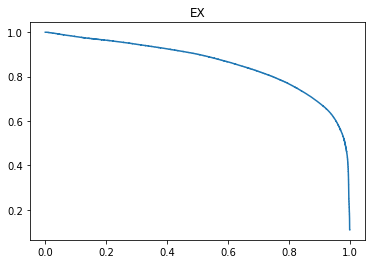

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:677: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


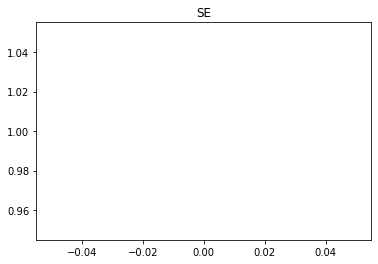

IDRiD_66


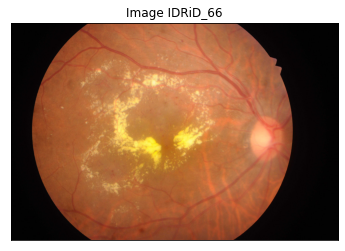

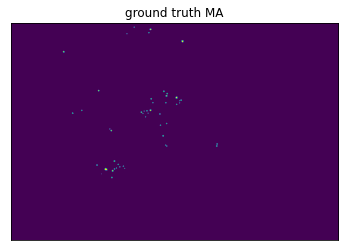

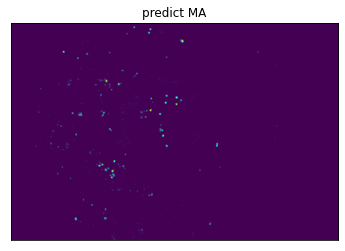

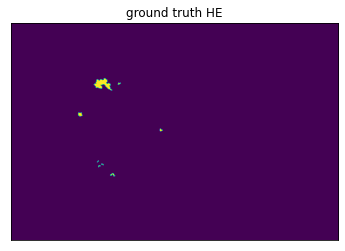

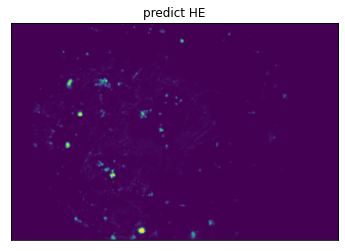

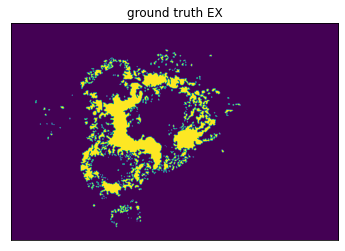

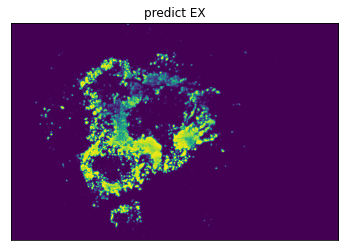

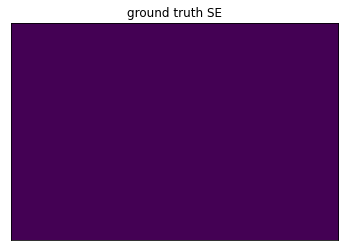

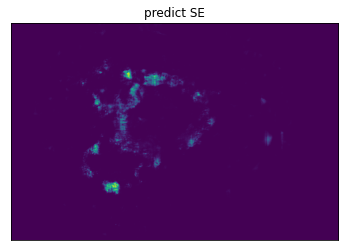

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3487: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


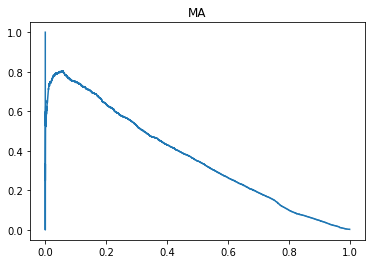

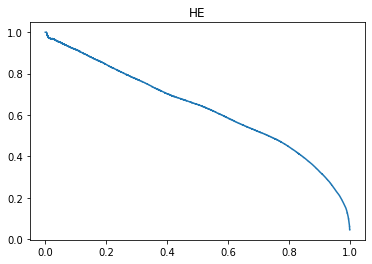

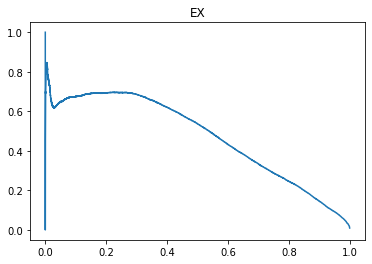

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:677: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


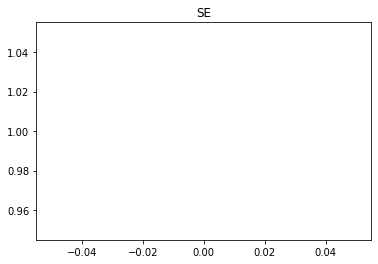

IDRiD_69


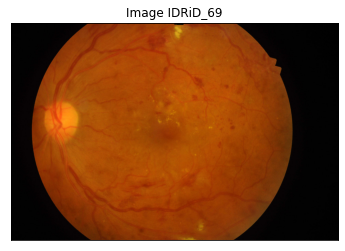

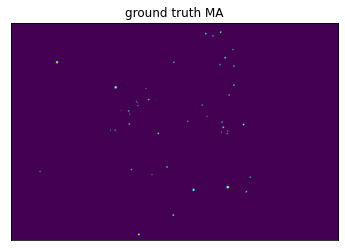

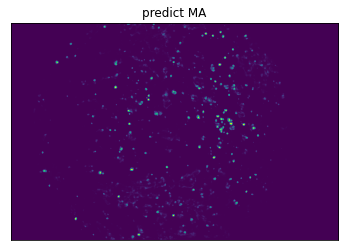

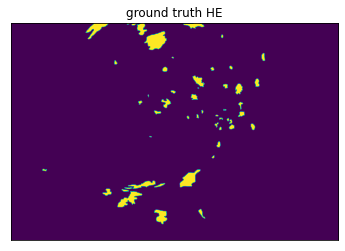

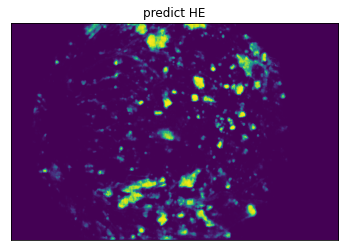

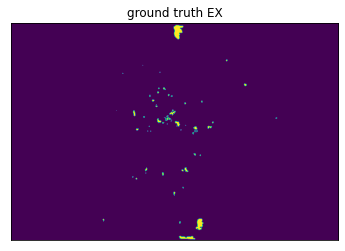

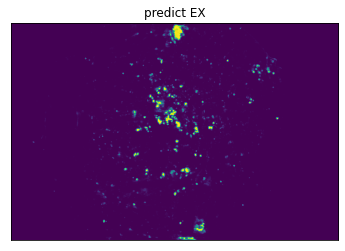

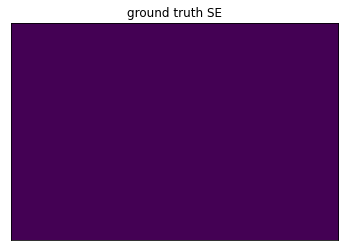

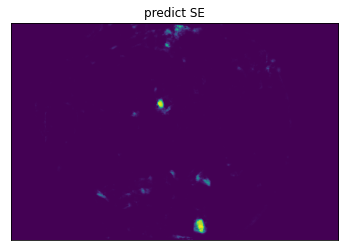

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3487: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


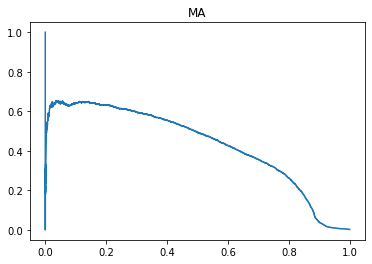

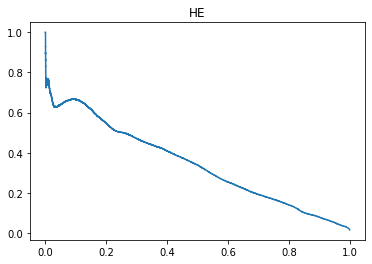

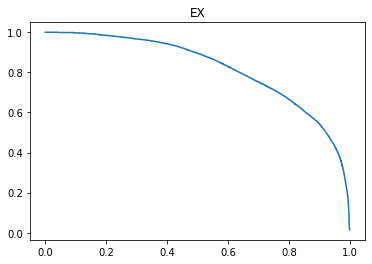

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:677: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


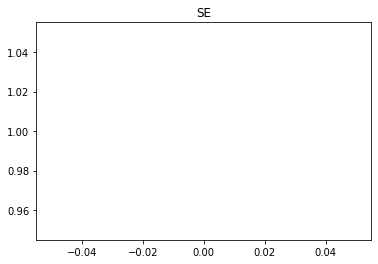

IDRiD_58


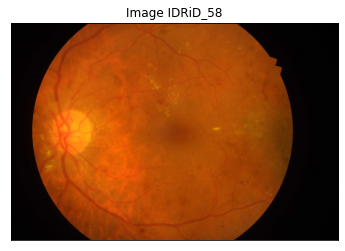

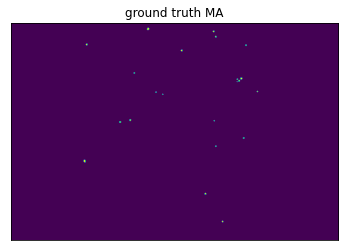

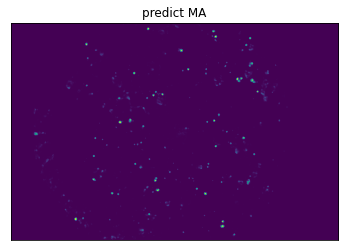

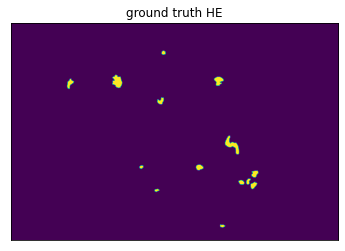

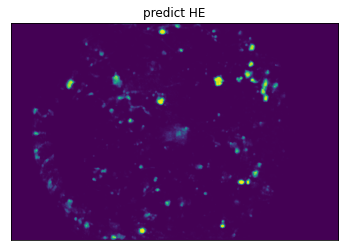

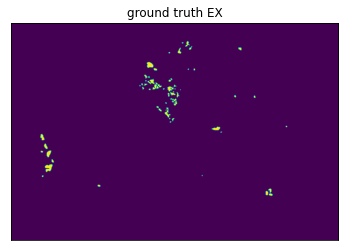

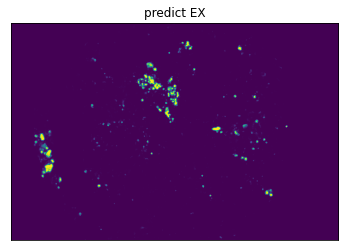

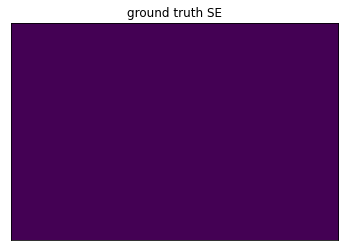

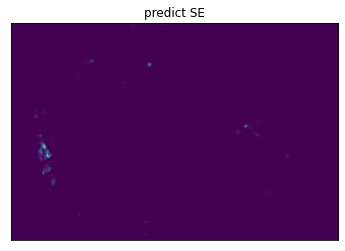

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3487: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


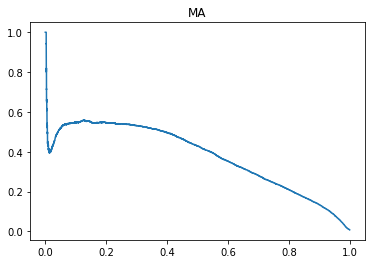

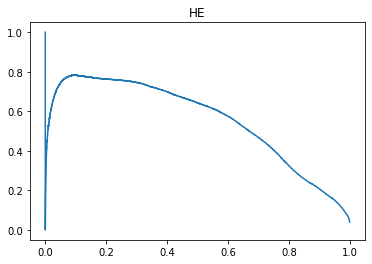

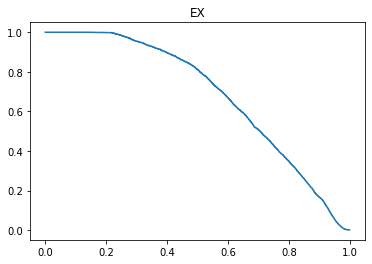

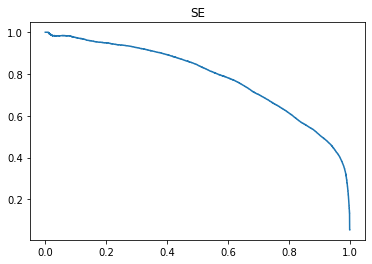

IDRiD_56


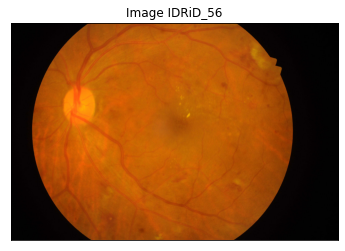

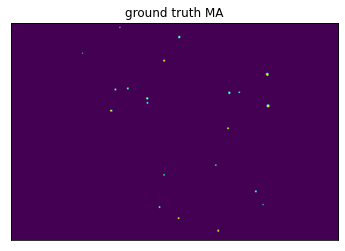

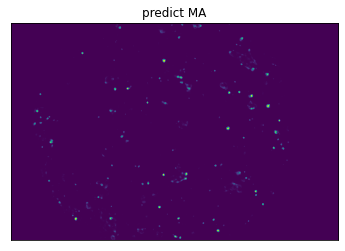

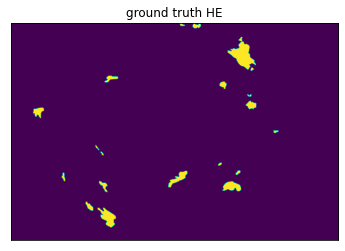

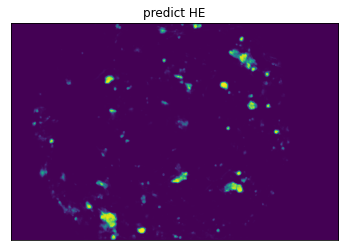

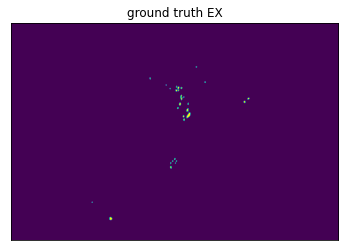

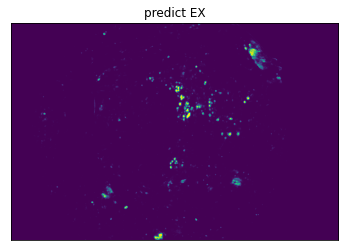

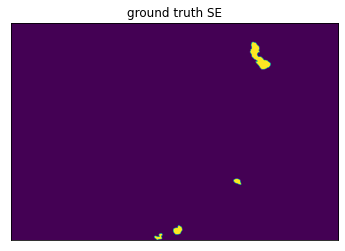

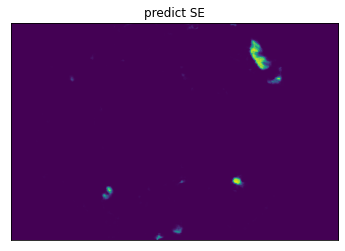

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3487: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


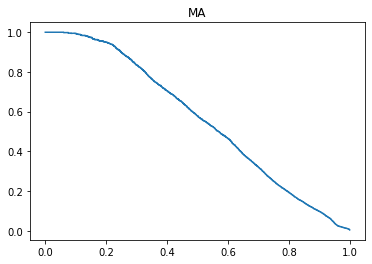

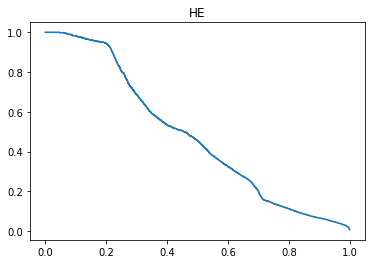

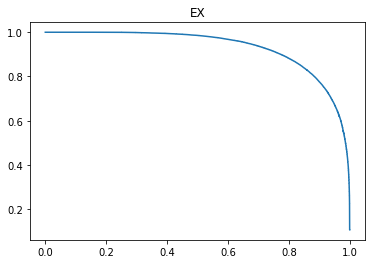

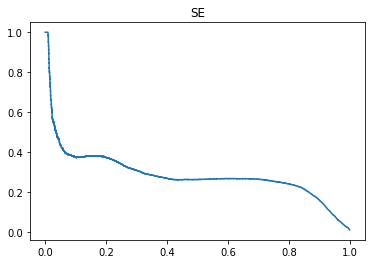

IDRiD_72


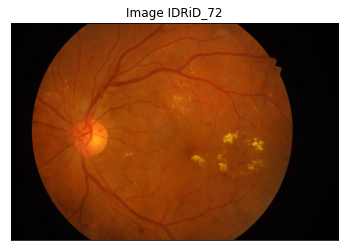

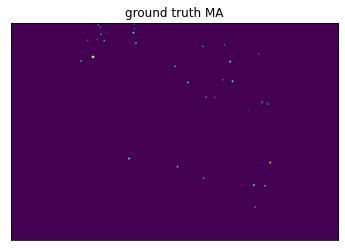

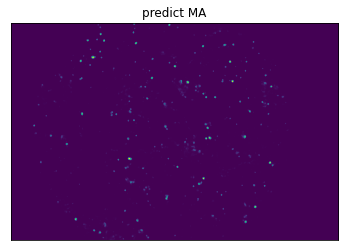

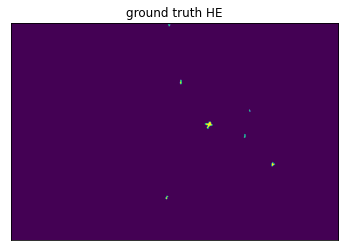

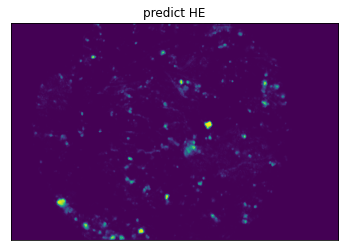

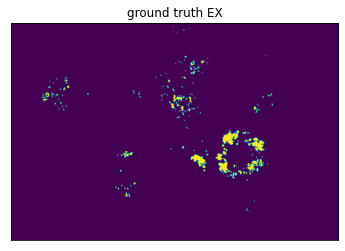

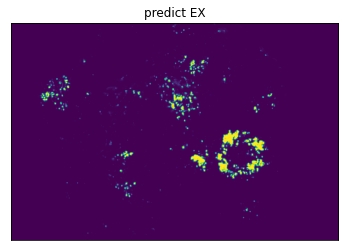

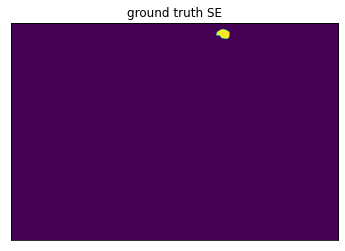

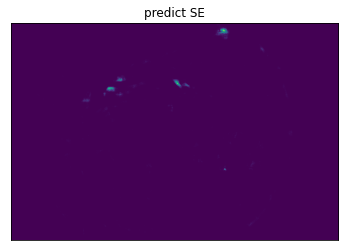

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3487: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


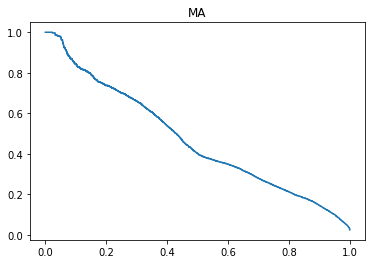

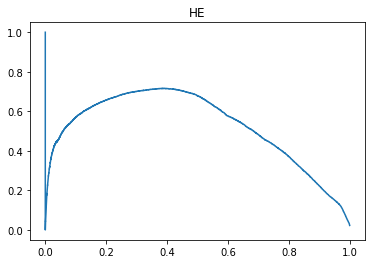

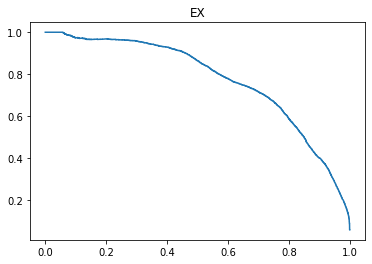

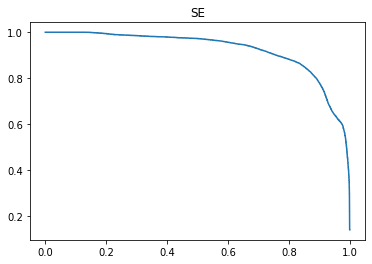

IDRiD_73


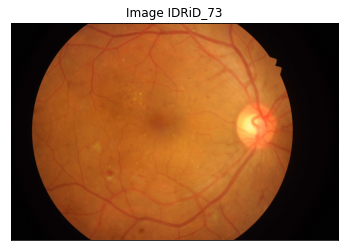

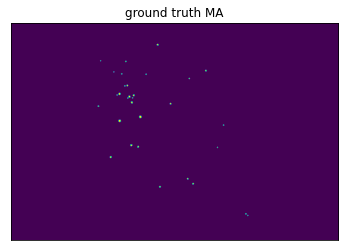

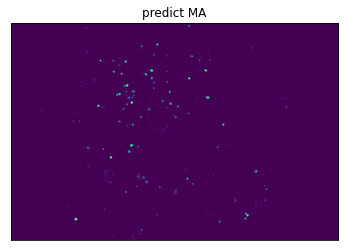

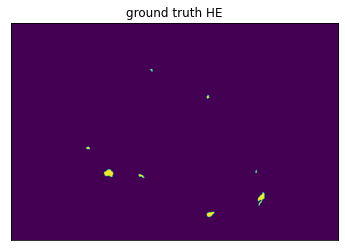

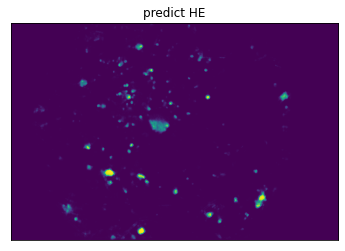

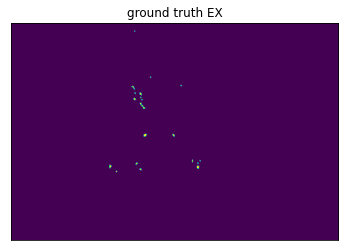

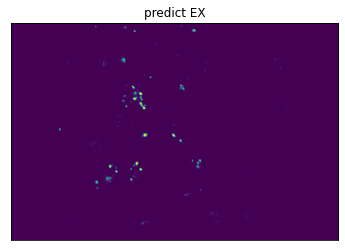

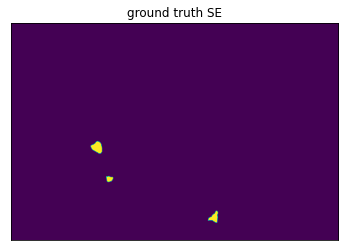

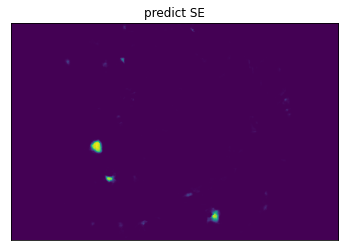

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3487: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


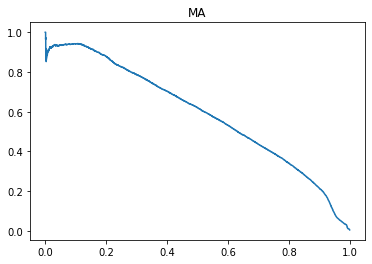

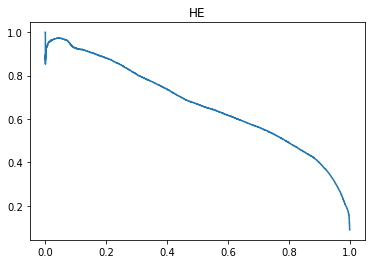

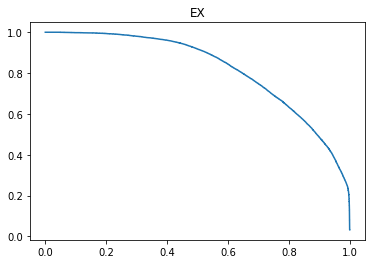

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:677: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


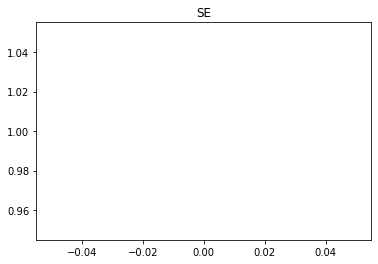

IDRiD_76


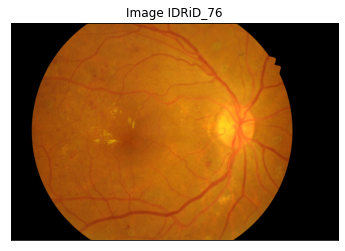

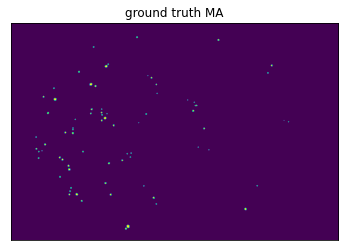

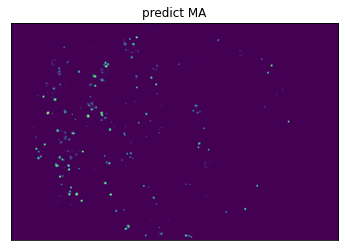

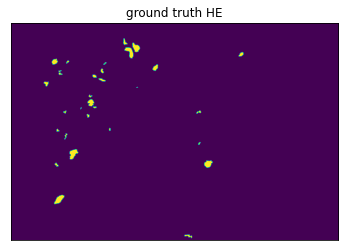

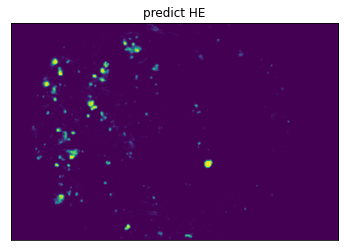

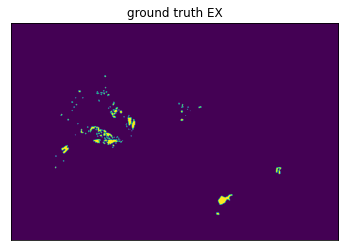

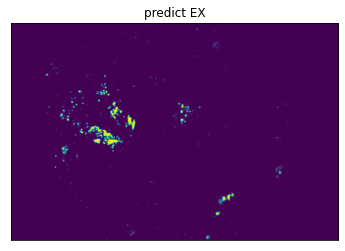

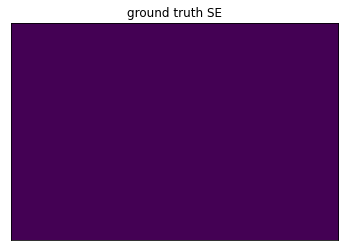

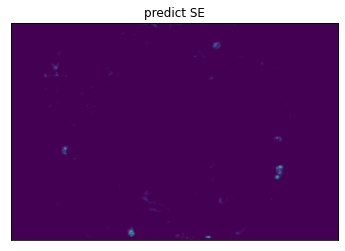

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3487: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


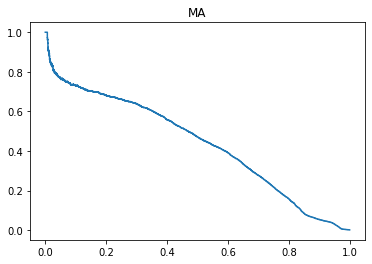

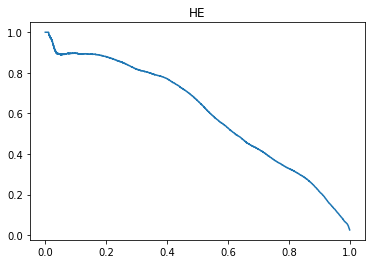

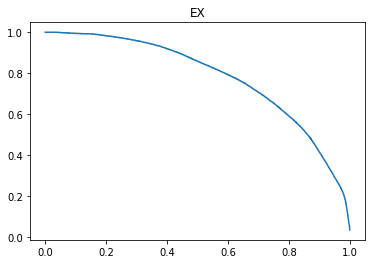

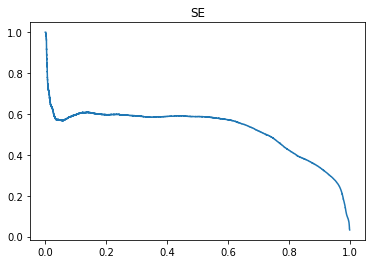

IDRiD_60


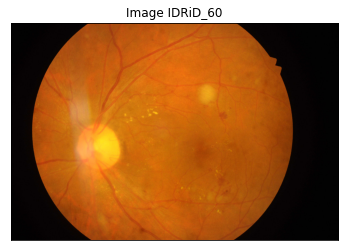

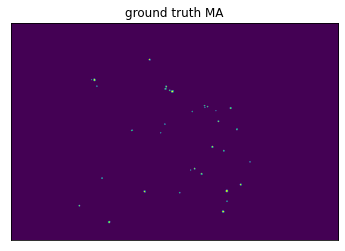

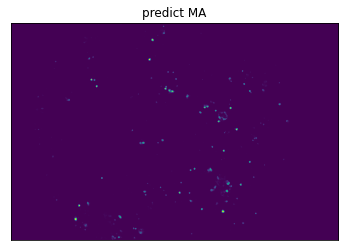

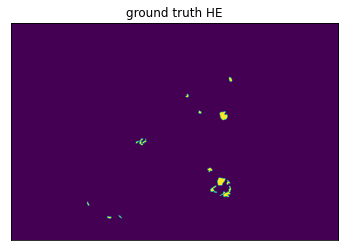

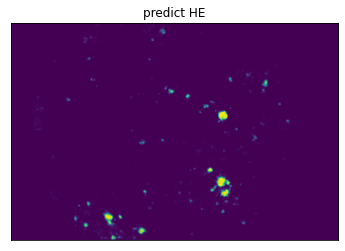

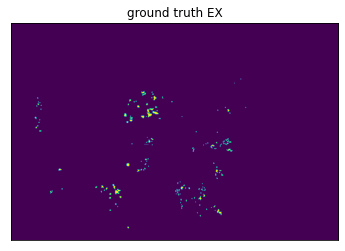

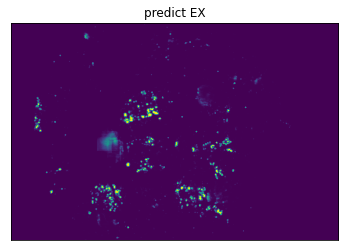

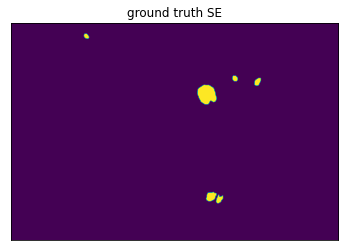

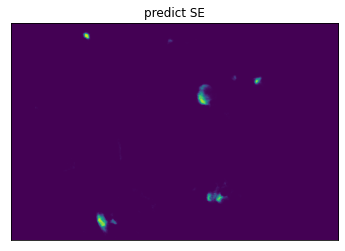

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3487: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


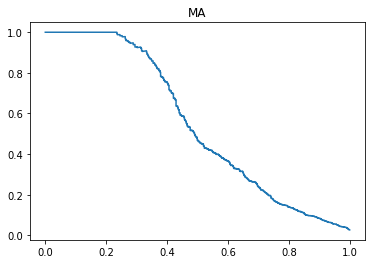

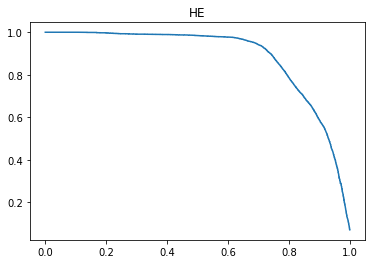

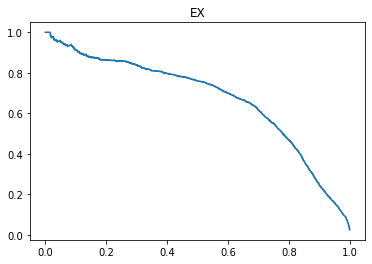

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:677: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


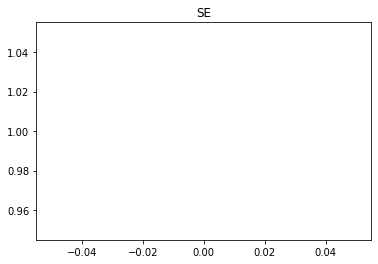

IDRiD_80


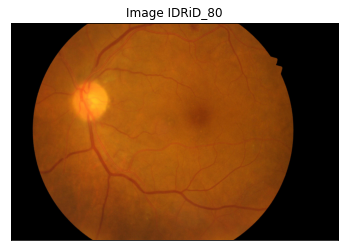

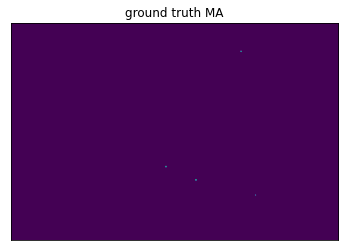

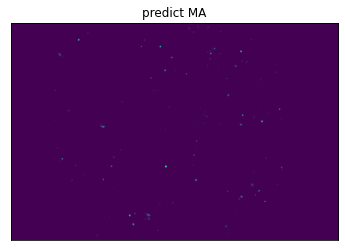

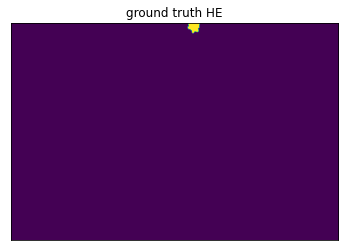

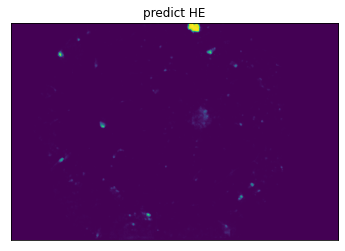

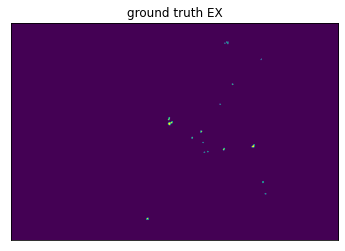

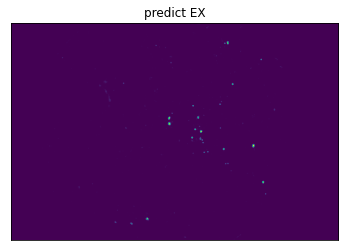

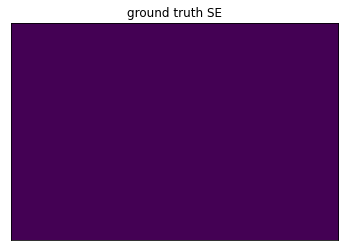

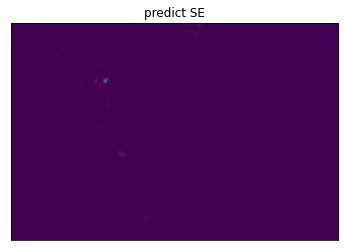

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3487: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


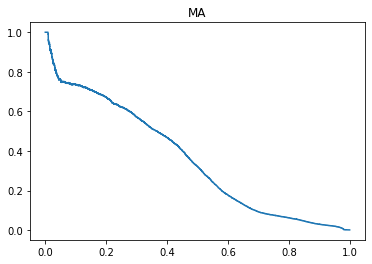

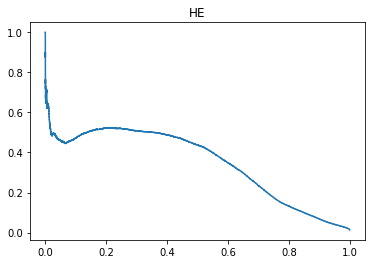

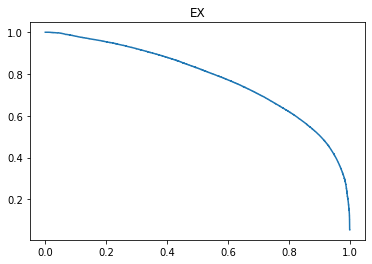

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:677: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


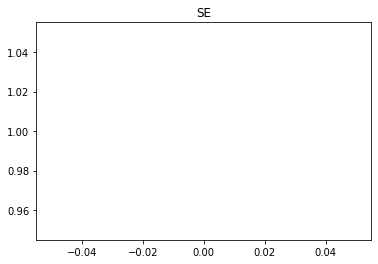

IDRiD_81


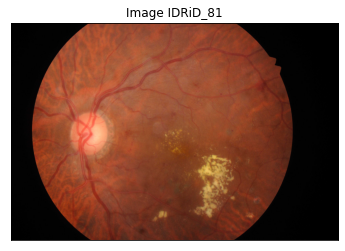

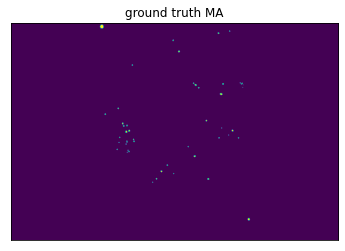

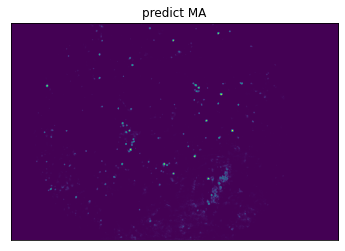

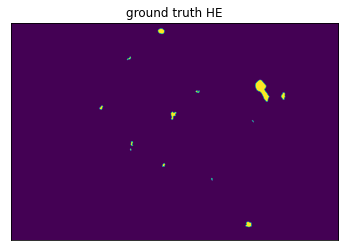

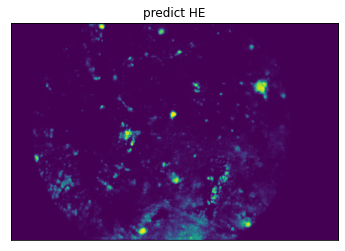

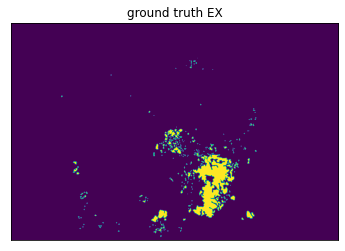

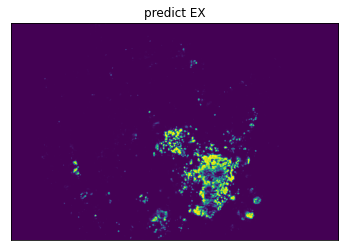

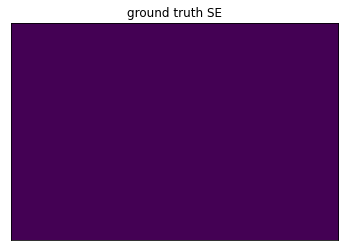

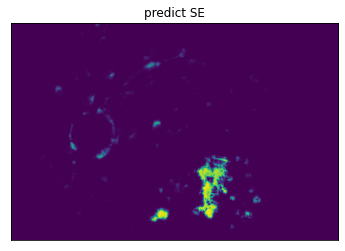

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3487: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


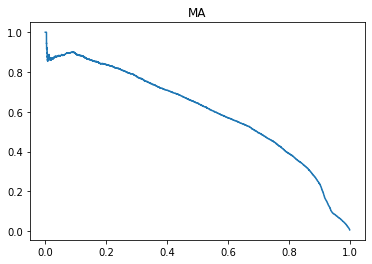

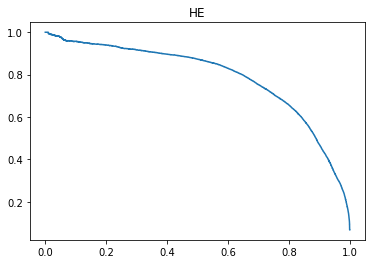

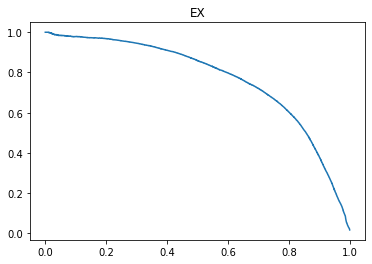

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:677: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


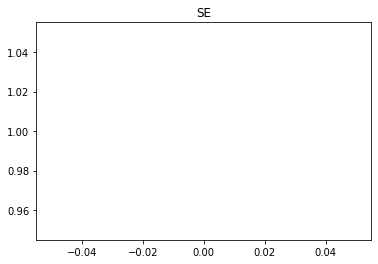

IDRiD_65


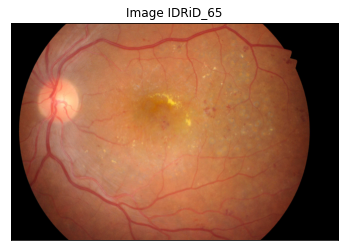

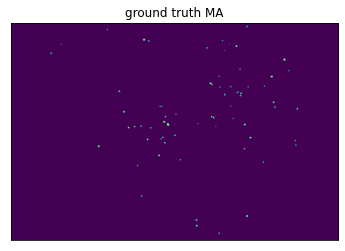

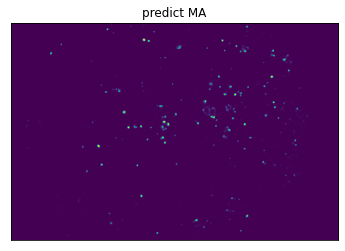

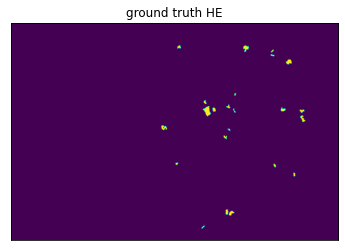

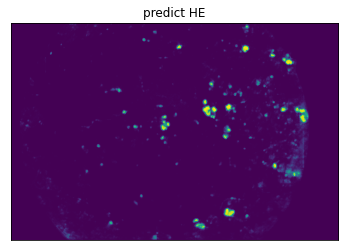

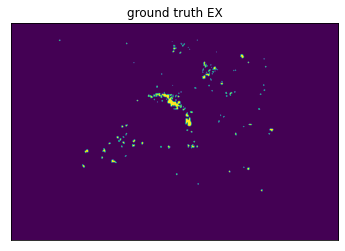

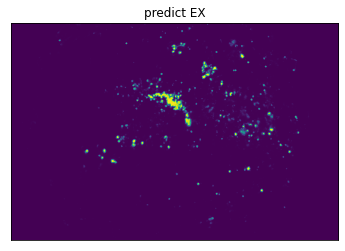

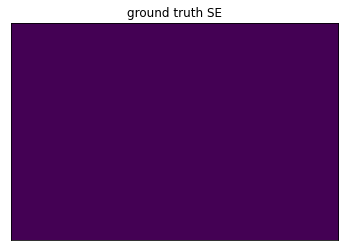

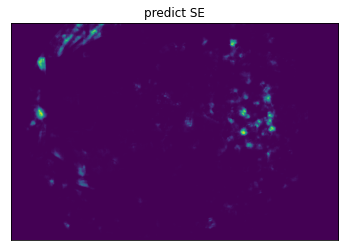

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3487: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


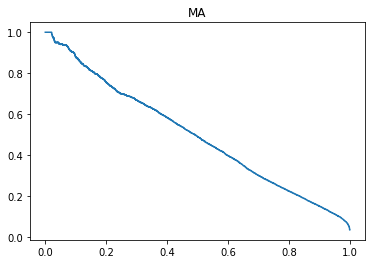

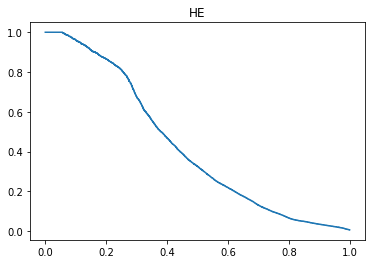

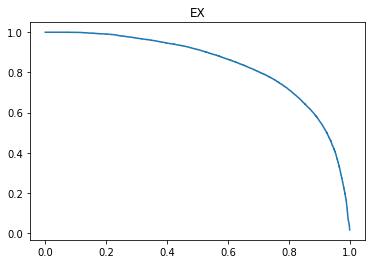

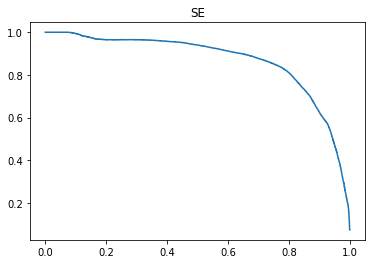

IDRiD_64


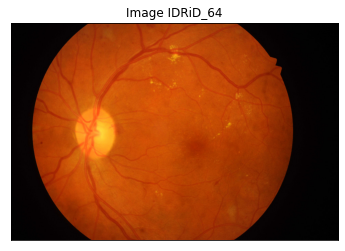

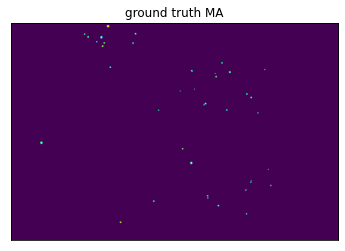

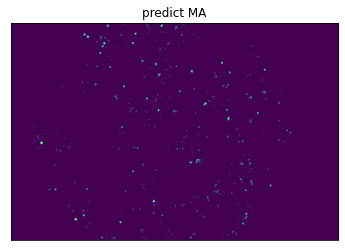

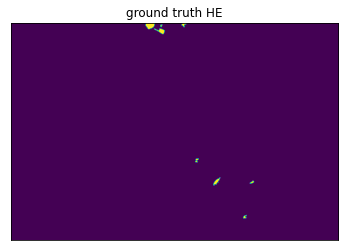

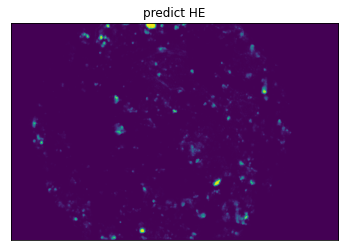

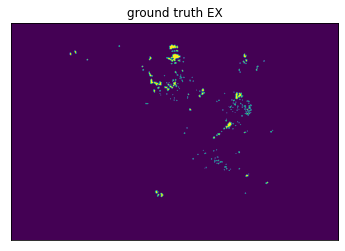

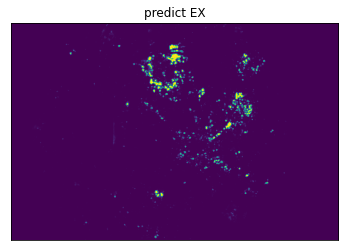

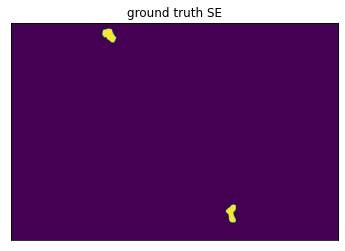

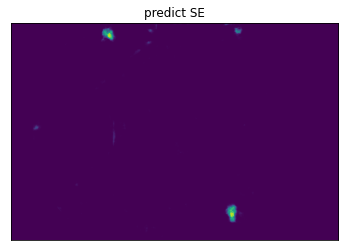

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3487: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


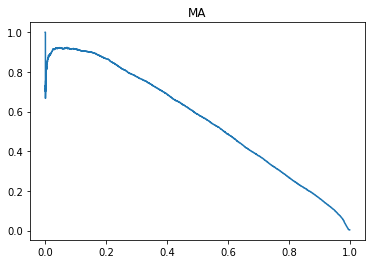

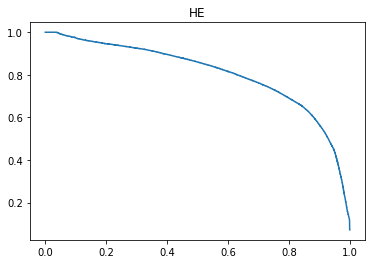

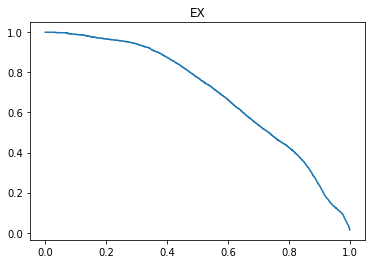

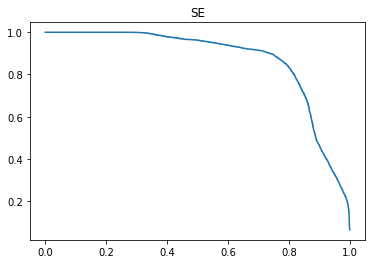

IDRiD_75


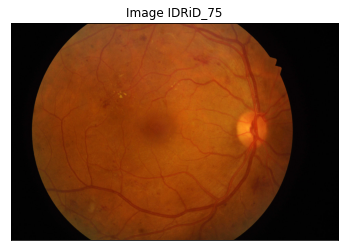

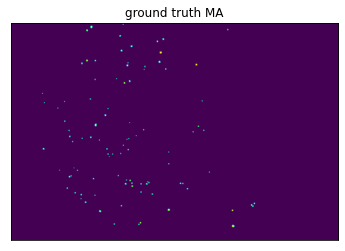

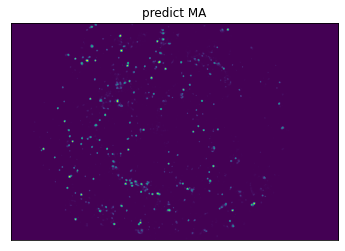

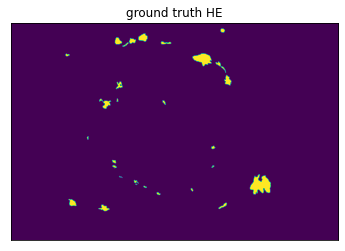

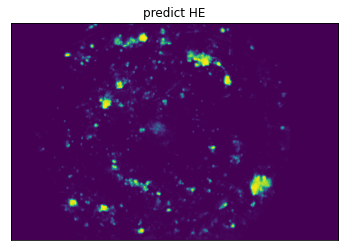

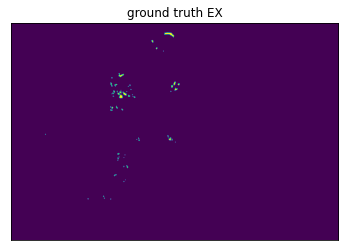

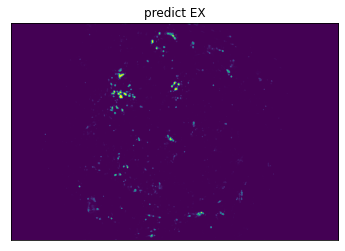

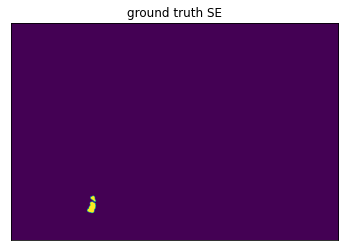

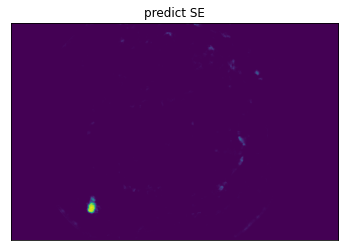

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3487: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


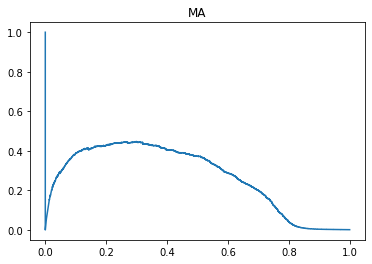

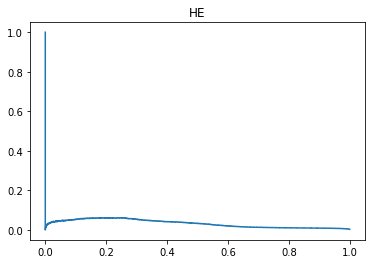

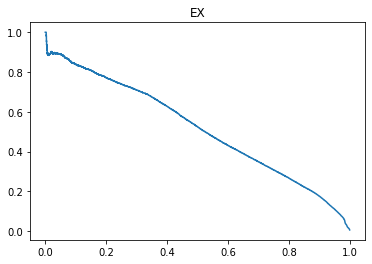

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:677: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


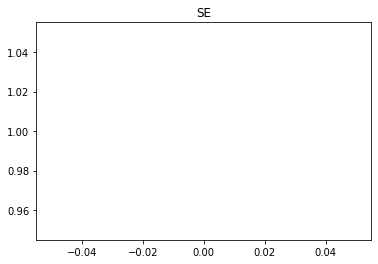

IDRiD_57


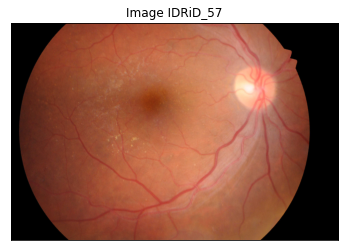

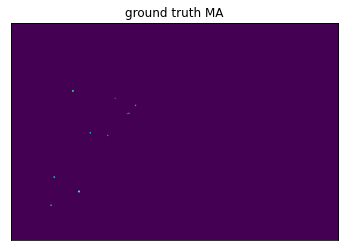

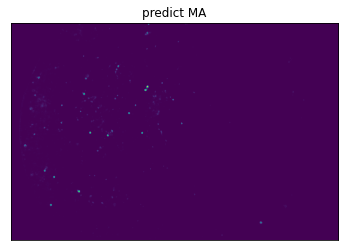

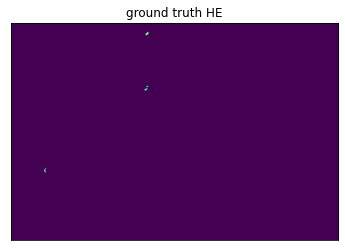

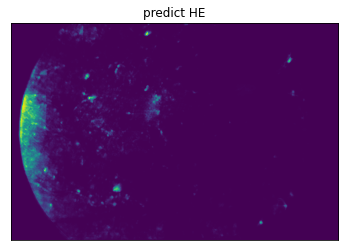

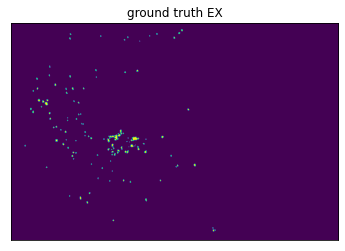

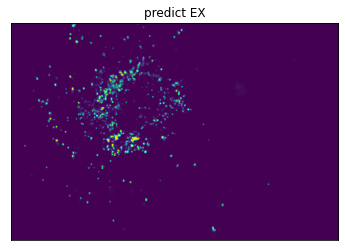

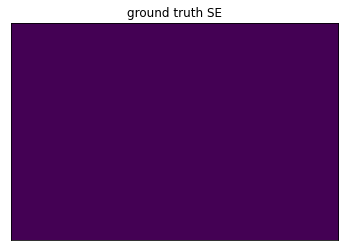

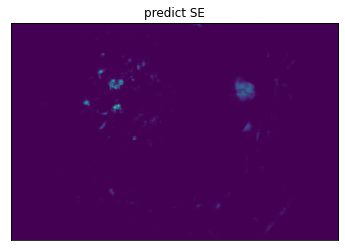

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3487: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


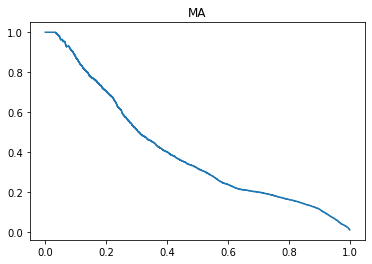

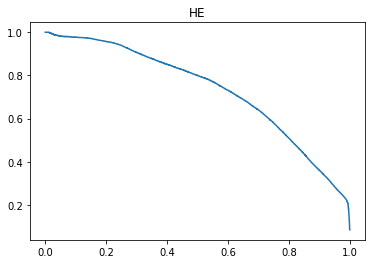

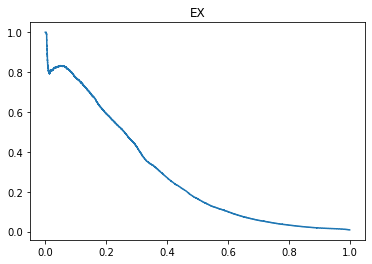

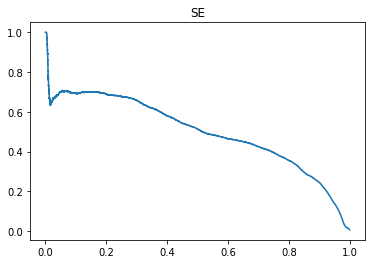

IDRiD_70


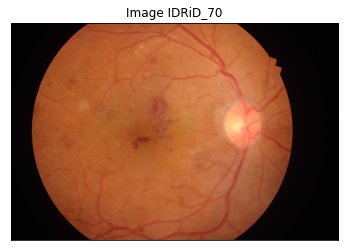

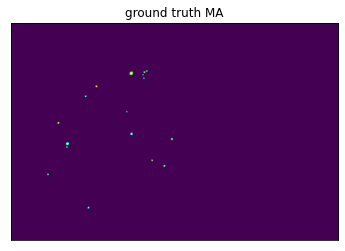

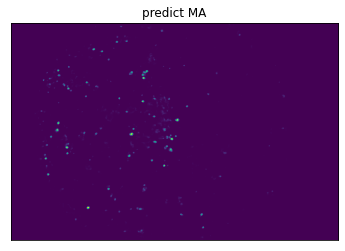

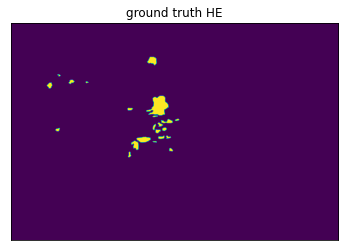

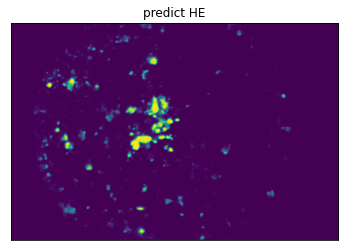

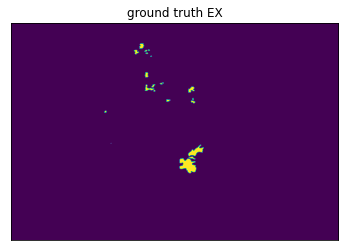

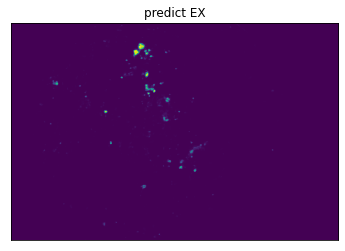

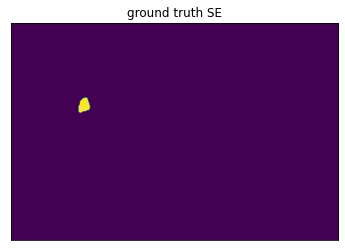

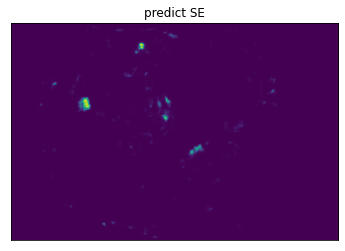

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3487: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


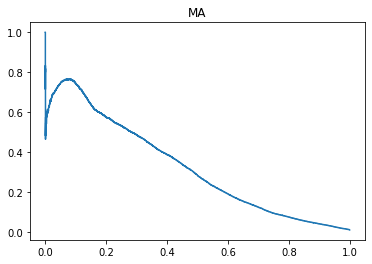

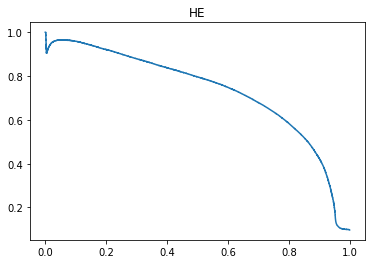

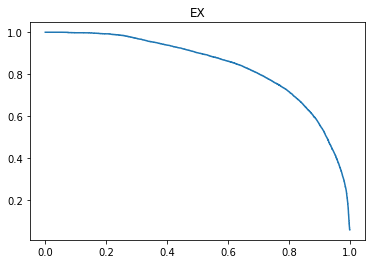

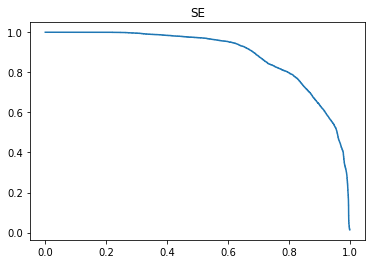

IDRiD_61


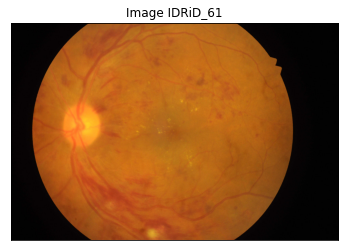

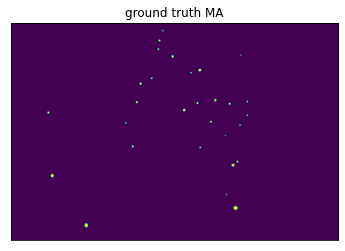

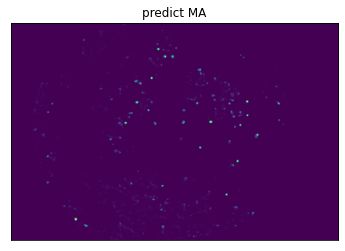

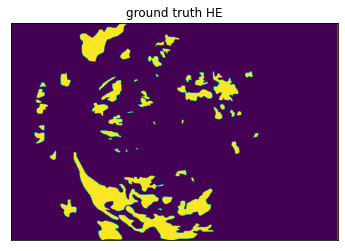

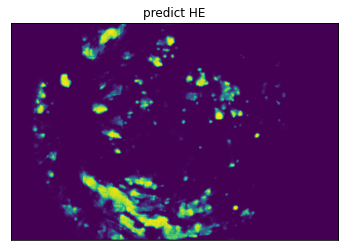

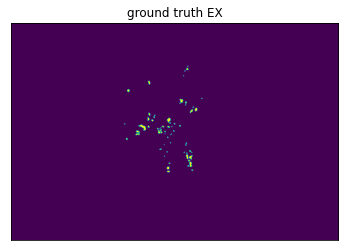

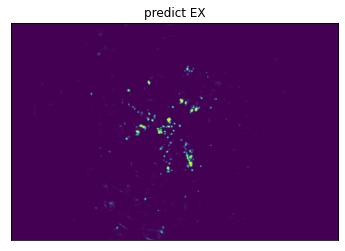

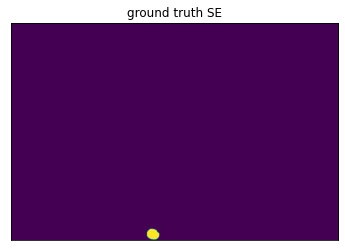

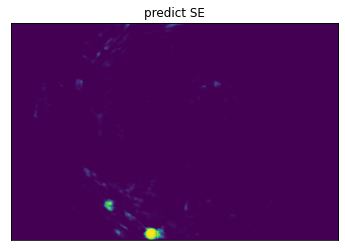

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3487: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


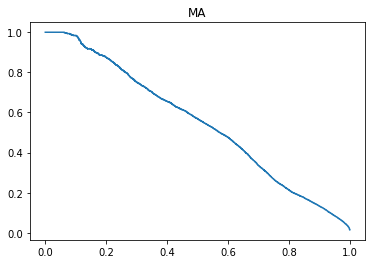

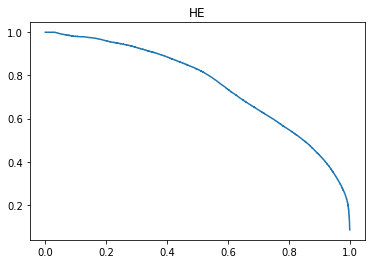

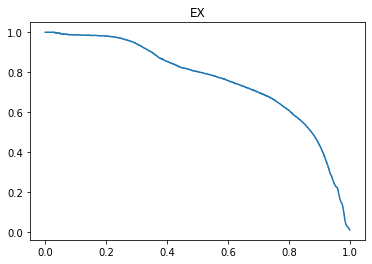

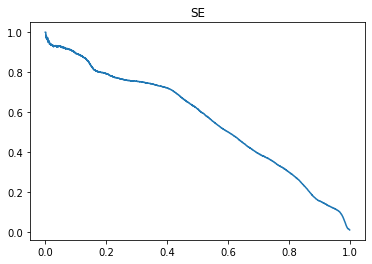

IDRiD_67


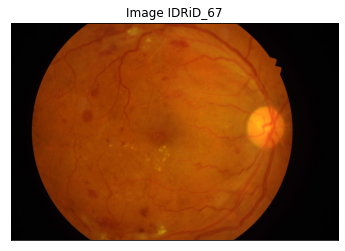

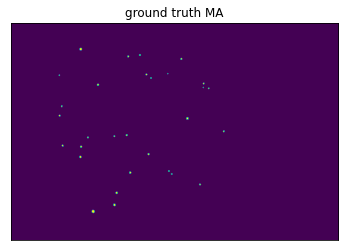

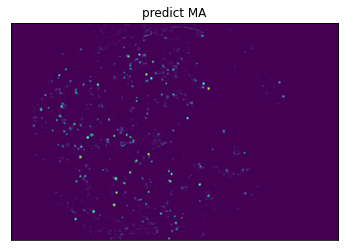

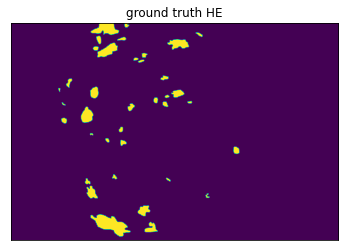

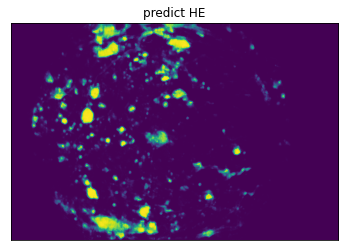

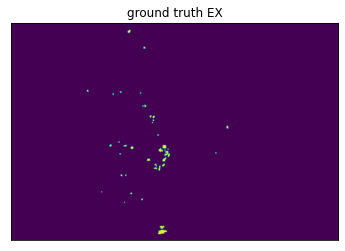

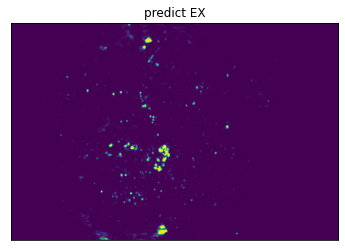

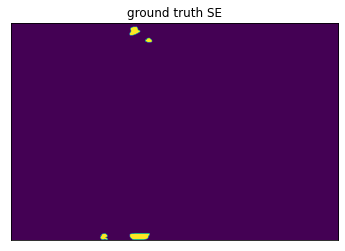

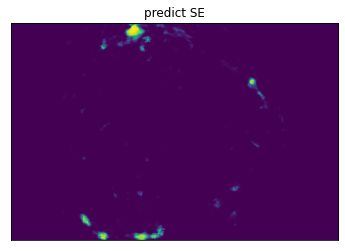

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3487: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


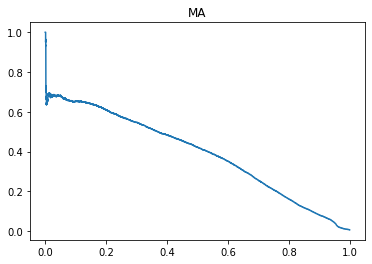

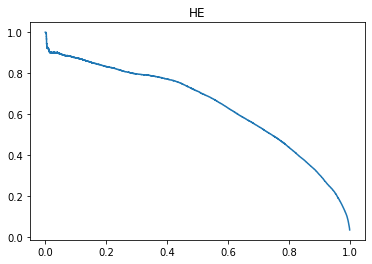

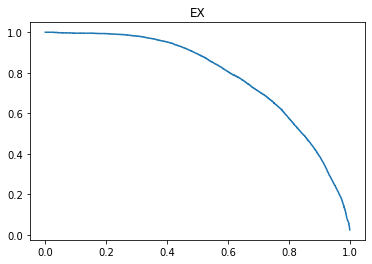

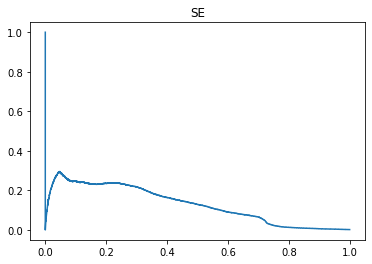

IDRiD_74


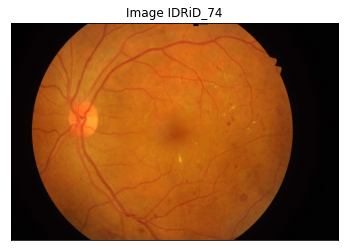

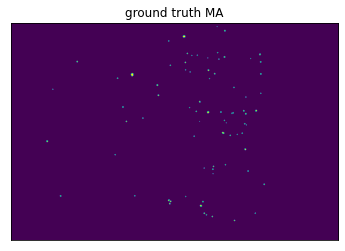

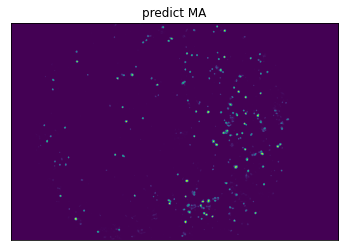

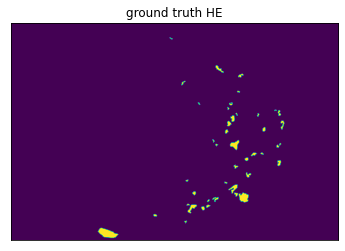

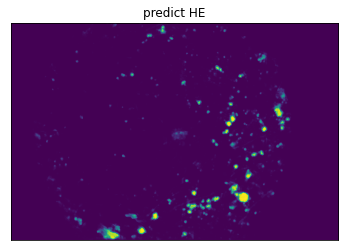

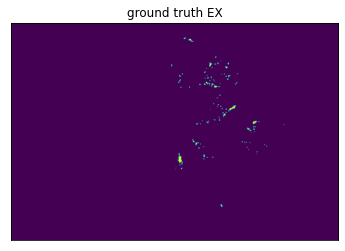

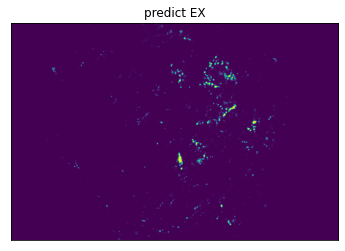

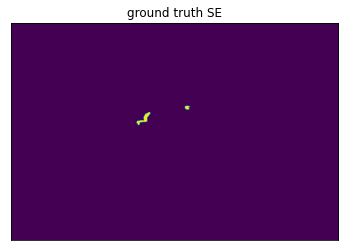

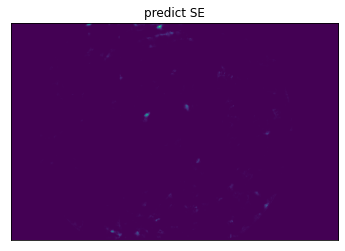

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3487: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


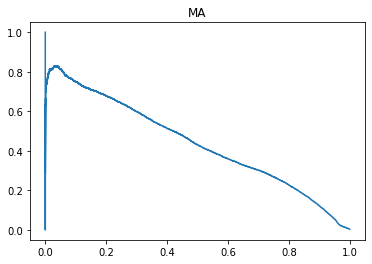

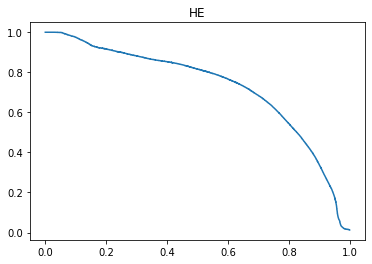

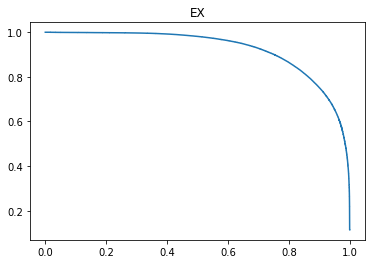

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:677: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


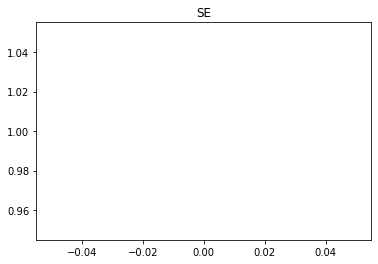

IDRiD_79


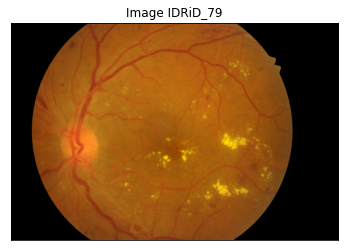

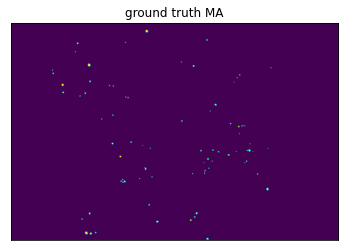

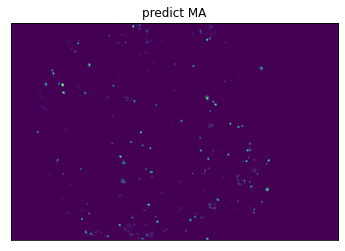

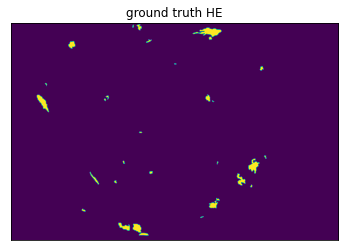

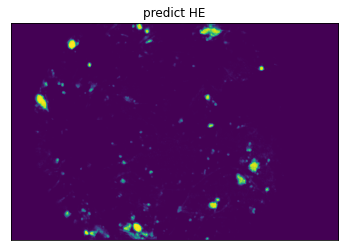

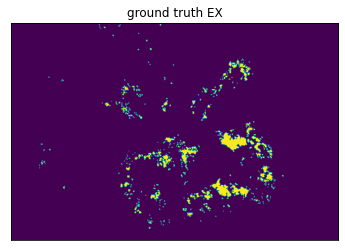

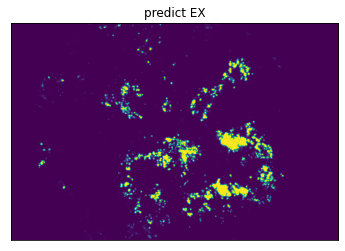

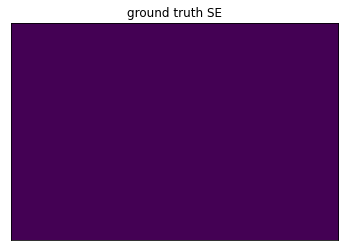

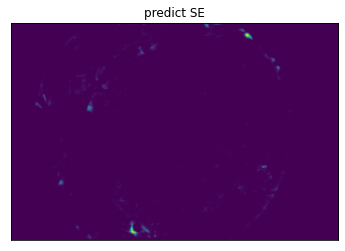

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3487: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


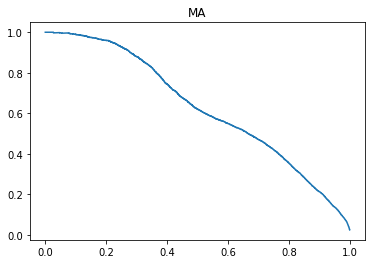

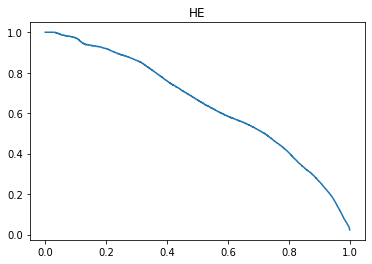

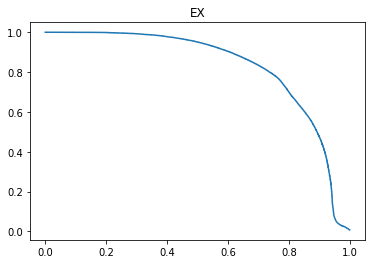

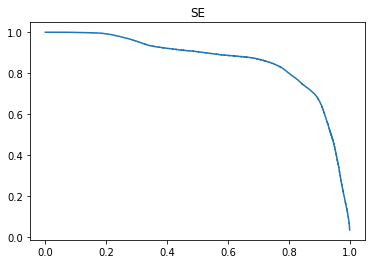

IDRiD_59


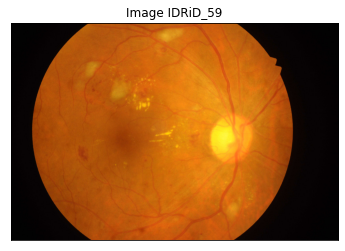

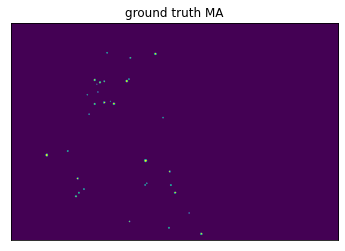

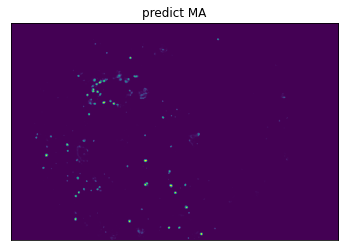

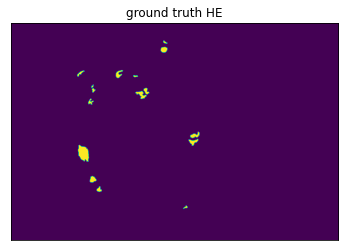

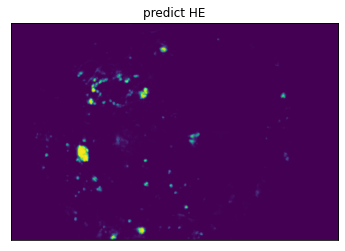

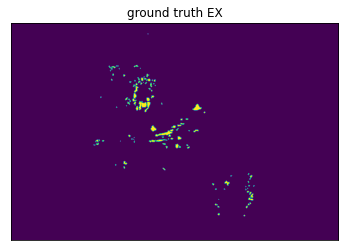

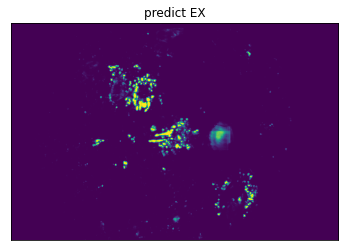

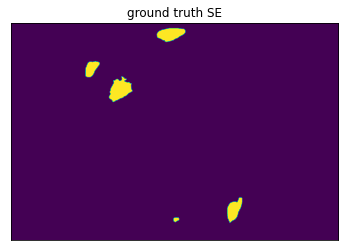

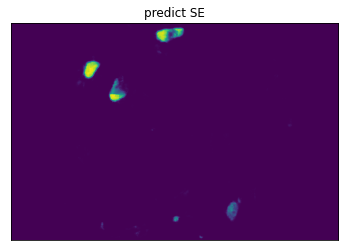

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3487: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


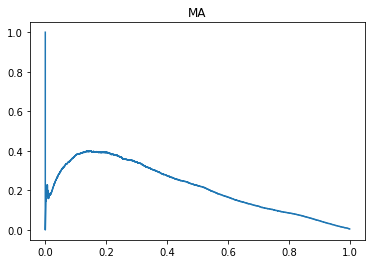

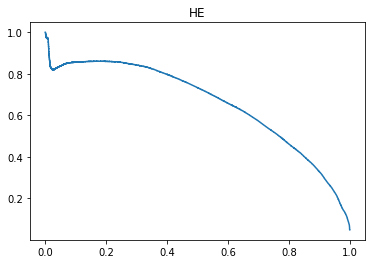

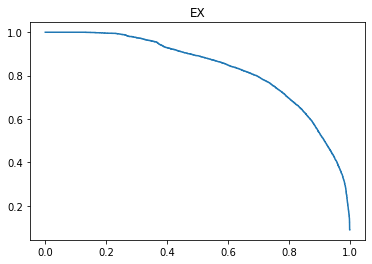

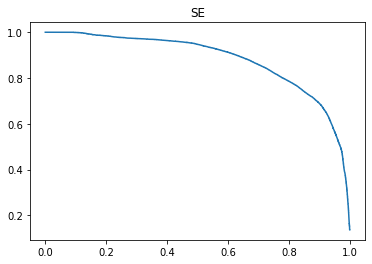

IDRiD_68


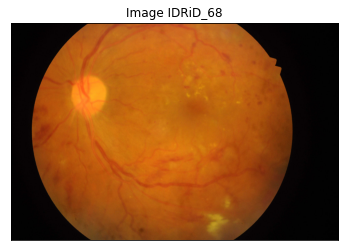

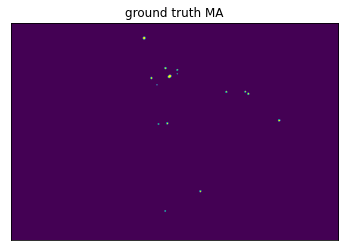

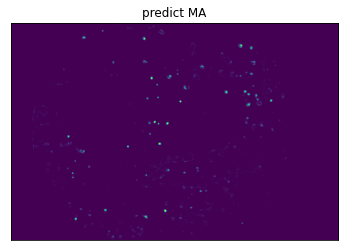

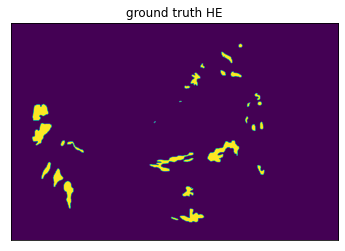

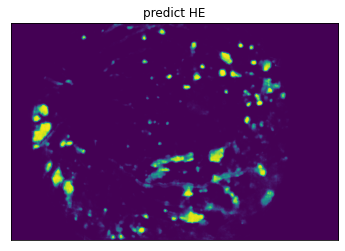

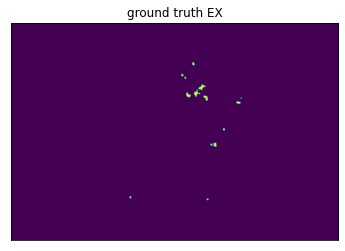

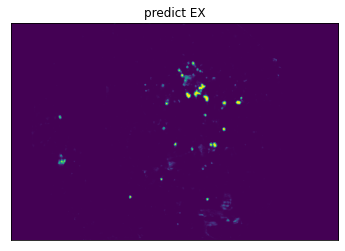

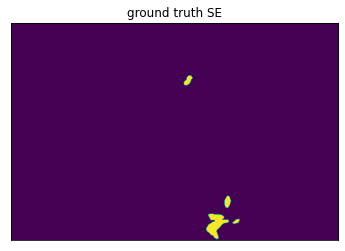

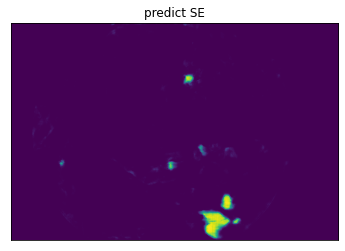

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3487: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


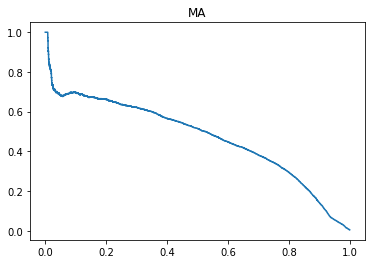

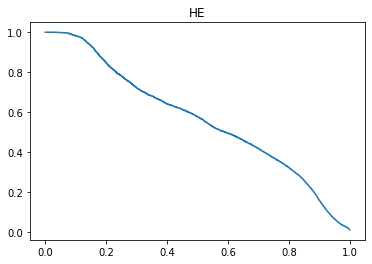

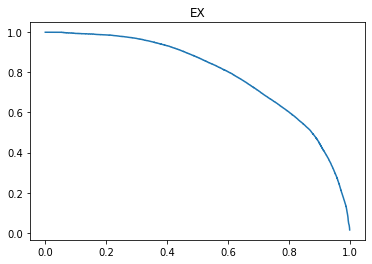

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:677: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


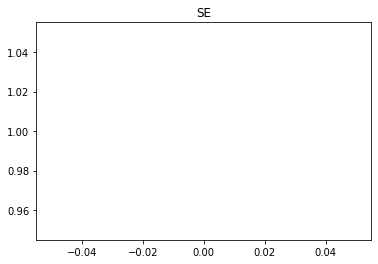

IDRiD_77


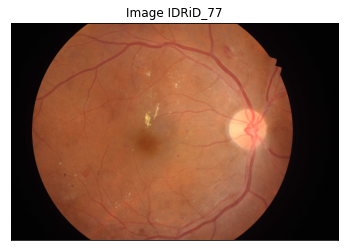

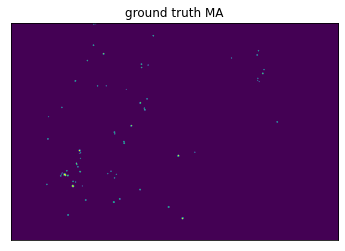

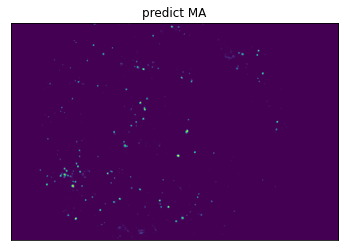

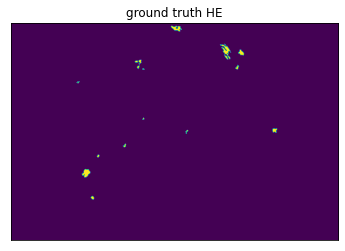

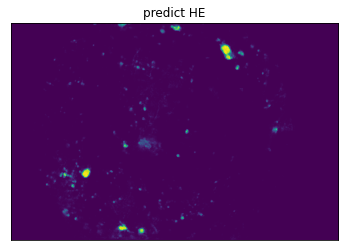

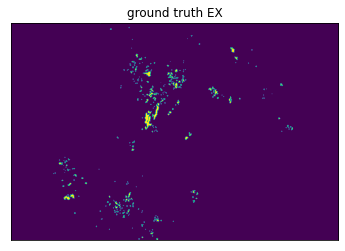

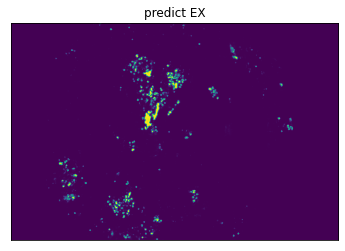

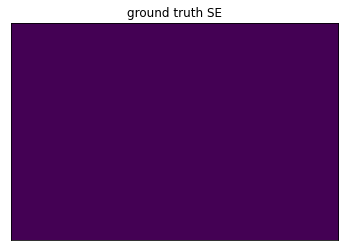

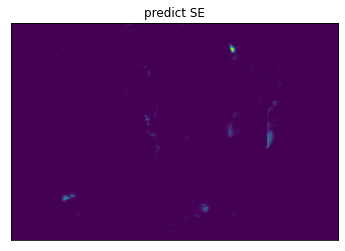

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3487: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


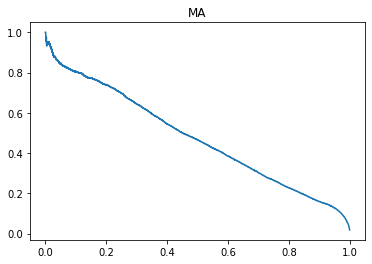

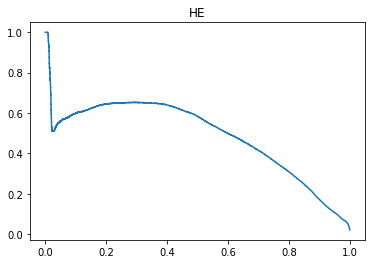

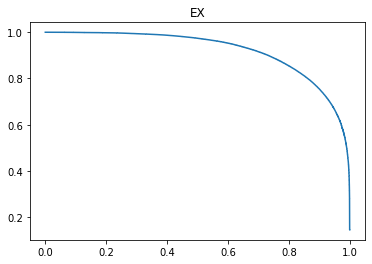

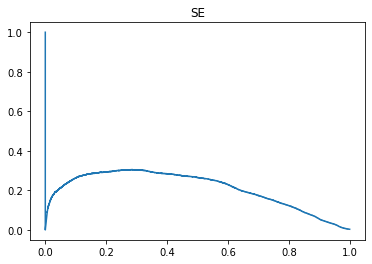

IDRiD_71


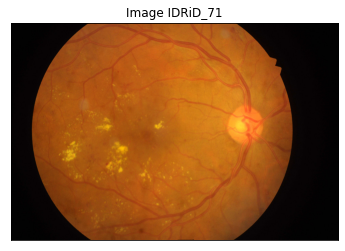

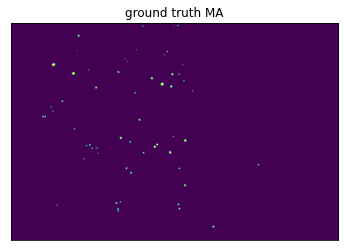

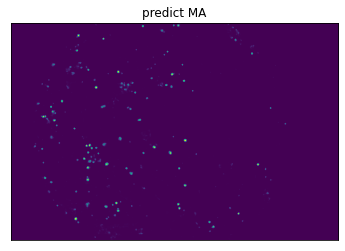

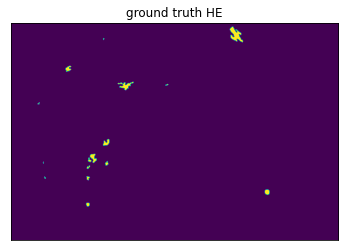

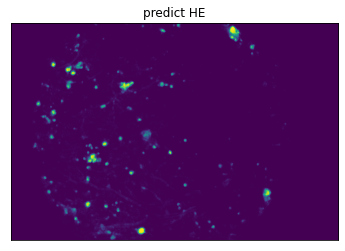

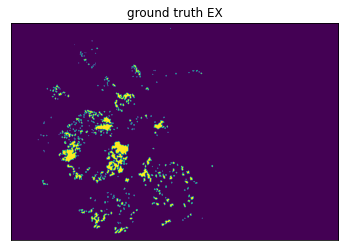

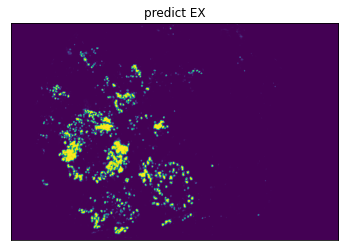

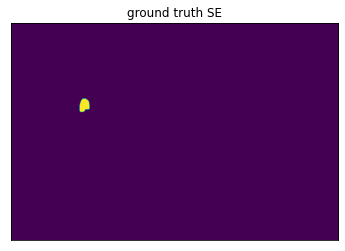

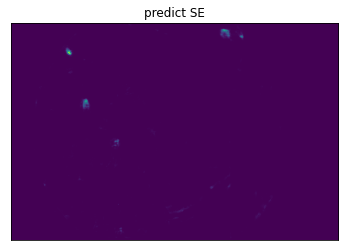

In [ ]:
# save each image separately

def show_image_sample():
    # dataset
    dataset = IDRiD_sub1_dataset(data_dir,transforms=0)
    print(len(dataset))
    
    #model
    model = GCN(4, 512)
    if use_gpu:
        model = model.cuda()
        #model = torch.nn.DataParallel(model).cuda()
    model.load_state_dict(torch.load(os.path.join(save_dir, save_model_name))) 
    model.train(False)
    for n in range(round(len(dataset)/54)):
        #test
        full_image = np.zeros((3, 37*2+2848, 40*2+4288), dtype='float32')
        # mask_full_image = np.zeros((3, 37*2+2848, 40*2+4288), dtype='int32')
        full_mask = np.zeros((4, 37*2+2848, 40*2+4288), dtype='float32')
        full_mask_patches_counter = np.zeros((37*2+2848, 40*2+4288), dtype='int32')
        full_output = np.zeros((4, 37*2+2848, 40*2+4288), dtype='float32')#(C, H, W)
        #mask_full_output = np.zeros((4, 37*2+2848, 40*2+4288), dtype='int32')
        title = ''
        for pp in range(10):
          for idx in range(9*6*n, 9*6*(n+1)):
              # print(idx)
              image, mask, name, corners = dataset[idx]
              title = name[:-8]
              #mask_patch=np.int32(mask_patch)
              if use_gpu:
                  image = image.cuda()
                  mask = mask.cuda()
              with torch.no_grad():
                  #forward
                  output = model(image.unsqueeze(0))
                  output = F.sigmoid(output)
                  output = output[0]
              
              output=np.array(output.cpu())
              output=output[:,15:497,15:497]
              mask=np.array(mask.cpu())
              mask=mask[:,15:497,15:497]
              image=np.array(image.cpu())
              image=image[:,15:497,15:497]


              full_mask_patches_counter[corners[0]:corners[1],corners[2]:corners[3]]+=1
              full_image[:,corners[0]:corners[1],corners[2]:corners[3]]=image
              full_mask[:,corners[0]:corners[1],corners[2]:corners[3]]=mask
              full_output[:,corners[0]:corners[1],corners[2]:corners[3]]+=output


        full_mask_patches_counter[full_mask_patches_counter==0]=1
        full_output=np.divide(full_output,full_mask_patches_counter)  

        full_image=full_image[:,37:37+2848,40:40+4288]
        full_mask=full_mask[:,37:37+2848,40:40+4288]
        full_output=full_output[:,37:37+2848,40:40+4288]
            
        full_image = full_image.transpose(1, 2, 0)
        MA = full_output[0]
        plot_aucpr(full_mask[0],MA,'MA')
        HE = full_output[1]
        plot_aucpr(full_mask[1],HE,'HE')
        EX = full_output[2]
        plot_aucpr(full_mask[2],EX,'EX')
        SE = full_output[3]
        plot_aucpr(full_mask[3],SE,'SE')

        print(title)
        if not os.path.exists(f'{results_dir}/full_size/{title}'):
          os.makedirs(f'{results_dir}/full_size/{title}')
        plt.figure()
        plt.title(f'Image {title}')
        fig = plt.imshow(full_image)
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)
        plt.savefig(f"{results_dir}/full_size/{title}/{title}.png")
        plt.show()

        plt.figure()
        plt.title('ground truth MA')
        fig = plt.imshow(full_mask[0])
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)
        plt.savefig(f"{results_dir}/full_size/{title}/ground truth MA.png")
        plt.show()

        plt.figure()
        plt.title('predict MA')
        fig = plt.imshow(MA)
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)
        plt.savefig(f"{results_dir}/full_size/{title}/predict MA.png")
        plt.show()

        plt.figure()
        plt.title('ground truth HE')
        fig = plt.imshow(full_mask[1])
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)
        plt.savefig(f"{results_dir}/full_size/{title}/ground truth HE.png")
        plt.show()

        plt.figure()
        plt.title('predict HE')
        fig = plt.imshow(HE)
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)
        plt.savefig(f"{results_dir}/full_size/{title}/predict HE.png")
        plt.show()

        plt.figure()
        plt.title('ground truth EX')
        fig = plt.imshow(full_mask[2])
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)
        plt.savefig(f"{results_dir}/full_size/{title}/ground truth EX.png")
        plt.show()

        plt.figure()
        plt.title('predict EX')
        fig = plt.imshow(EX)
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)
        plt.savefig(f"{results_dir}/full_size/{title}/predict EX.png")
        plt.show()

        plt.figure()
        plt.title('ground truth SE')
        fig = plt.imshow(full_mask[3])
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)
        plt.savefig(f"{results_dir}/full_size/{title}/ground truth SE.png")
        plt.show()

        plt.figure()
        plt.title('predict SE')
        fig = plt.imshow(SE)
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)
        plt.savefig(f"{results_dir}/full_size/{title}/predict SE.png")
        plt.show()
        

if __name__ == '__main__':
    show_image_sample()

In [ ]:
#calculate vectors auc_full_mask,auc_full_output (330millions pixels in total, all images)
# later use to calculate AUCPR in personal computer, because colab crash when running it here

def results_stadistics():
    # dataset
    dataset = IDRiD_sub1_dataset(data_dir,transforms=0)
    print(len(dataset))
    auc_full_mask = np.zeros((round(len(dataset)/54),4, 2848, 4288), dtype='float16')
    auc_full_output = np.zeros((round(len(dataset)/54),4, 2848, 4288), dtype='float16')
    #model
    model = GCN(4, 512)
    if use_gpu:
        model = model.cuda()
        #model = torch.nn.DataParallel(model).cuda()
    model.load_state_dict(torch.load(os.path.join(save_dir, save_model_name))) 
    model.train(False)
    for n in range(round(len(dataset)/54)):
        #test
        full_image = np.zeros((3, 37*2+2848, 40*2+4288), dtype='float16')
        # mask_full_image = np.zeros((3, 37*2+2848, 40*2+4288), dtype='int32')
        full_mask = np.zeros((4, 37*2+2848, 40*2+4288), dtype='float16')
        full_mask_patches_counter = np.zeros((37*2+2848, 40*2+4288), dtype='int8')
        full_output = np.zeros((4, 37*2+2848, 40*2+4288), dtype='float16')#(C, H, W)
        #mask_full_output = np.zeros((4, 37*2+2848, 40*2+4288), dtype='int32')
        title = ''
        for pp in range(10):
          for idx in range(9*6*n, 9*6*(n+1)):
              # print(idx)
              image, mask, name, corners = dataset[idx]
              title = name[:-8]
              #mask_patch=np.int32(mask_patch)
              if use_gpu:
                  image = image.cuda()
                  mask = mask.cuda()
              with torch.no_grad():
                  #forward
                  output = model(image.unsqueeze(0))
                  output = F.sigmoid(output)
                  output = output[0]
              
              output=np.array(output.cpu())
              output=output[:,15:497,15:497]
              mask=np.array(mask.cpu())
              mask=mask[:,15:497,15:497]
              image=np.array(image.cpu())
              image=image[:,15:497,15:497]
              # print(mask.shape)

              full_mask_patches_counter[corners[0]:corners[1],corners[2]:corners[3]]+=1
              full_image[:,corners[0]:corners[1],corners[2]:corners[3]]=np.float16(image)
              full_mask[:,corners[0]:corners[1],corners[2]:corners[3]]=np.float16(mask)
              full_output[:,corners[0]:corners[1],corners[2]:corners[3]]+=np.float16(output)
              # print(pp)

        full_mask_patches_counter[full_mask_patches_counter==0]=1
        full_output=np.divide(full_output,full_mask_patches_counter)  

        full_image=full_image[:,37:37+2848,40:40+4288]
        full_mask=full_mask[:,37:37+2848,40:40+4288]
        auc_full_mask[n,:,:,:]=full_mask
        full_output=full_output[:,37:37+2848,40:40+4288]
        auc_full_output[n,:,:,:]=full_output
            
        full_image = full_image.transpose(1, 2, 0)
        MA = full_output[0]
        plot_aucpr(full_mask[0],MA,'MA')
        HE = full_output[1]
        plot_aucpr(full_mask[1],HE,'HE')
        EX = full_output[2]
        plot_aucpr(full_mask[2],EX,'EX')
        SE = full_output[3]
        plot_aucpr(full_mask[3],SE,'SE')

        print(title)
       
    return auc_full_mask,auc_full_output  

def calculate_plot_aucpr_ind(auc_full_mask,auc_full_output,str='!'):
    print(auc_full_mask.flatten().shape)
    print(auc_full_output.flatten().shape)
    precision, recall, th= precision_recall_curve(auc_full_mask.flatten(),auc_full_output.flatten())
    print(recall.shape)
    plt.figure()
    plt.plot(recall)
    plt.title(f'recall_{str}')
    plt.show()
        
    print(f'AUC Precision Recall {str}: {auc(recall,precision)}')

1458


Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/hub/checkpoints/resnet152-b121ed2d.pth


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.


(4, 2922, 4368)


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3328: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


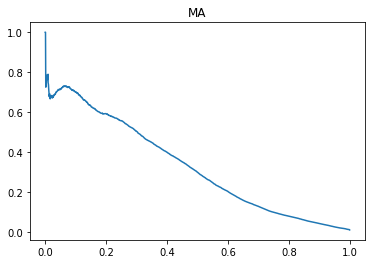

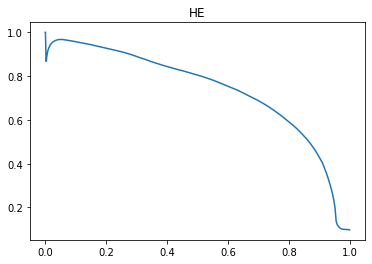

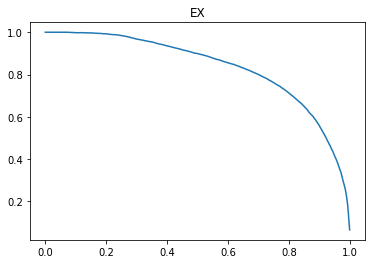

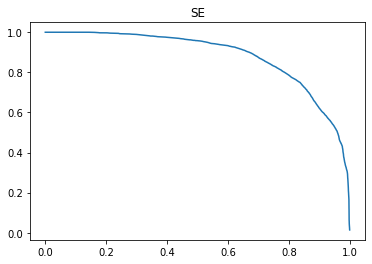

IDRiD_61
(4, 2922, 4368)


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3328: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


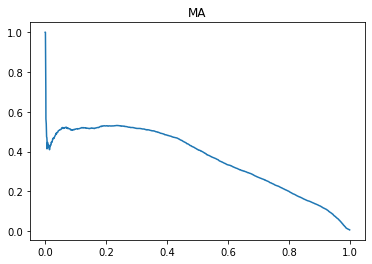

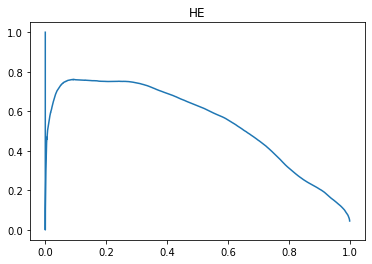

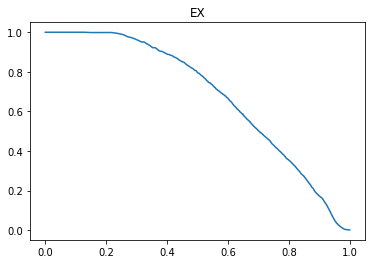

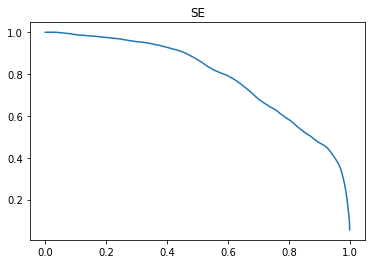

IDRiD_56
(4, 2922, 4368)


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3328: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


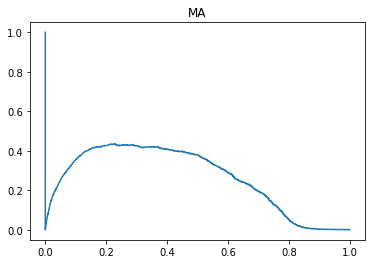

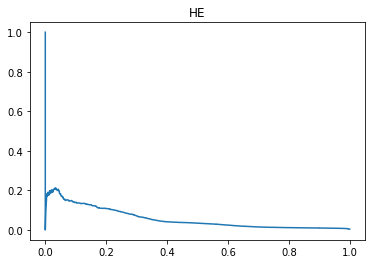

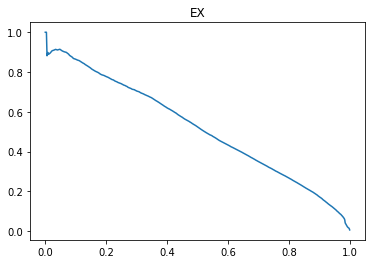

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:677: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


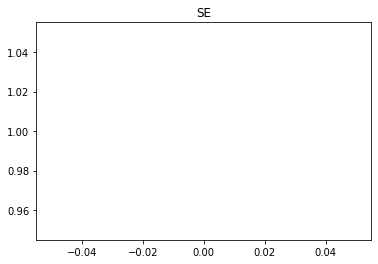

IDRiD_57
(4, 2922, 4368)


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3328: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


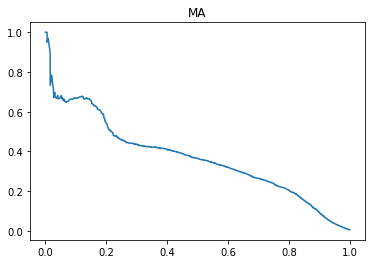

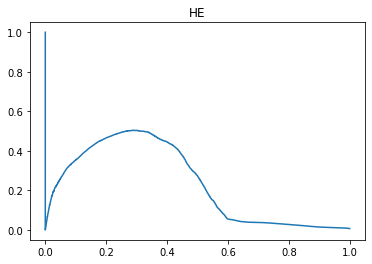

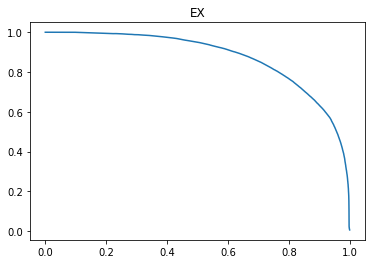

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:677: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


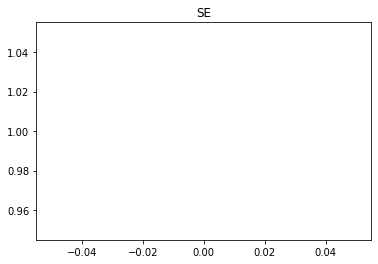

IDRiD_62
(4, 2922, 4368)


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3328: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


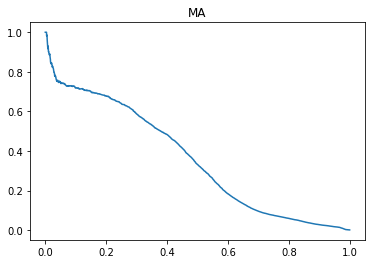

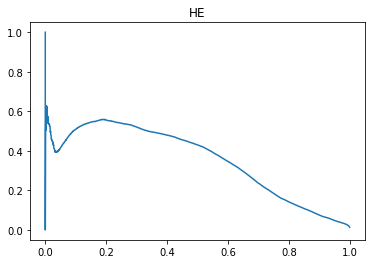

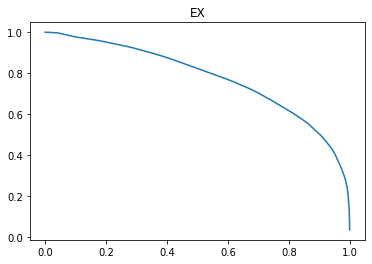

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:677: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


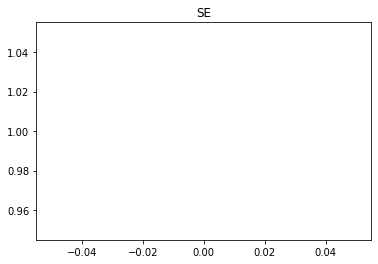

IDRiD_81
(4, 2922, 4368)


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3328: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


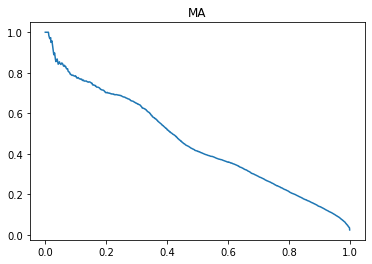

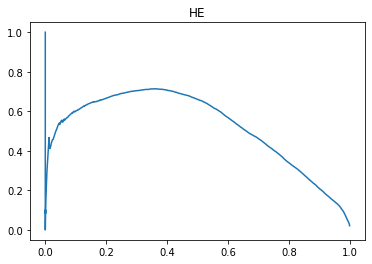

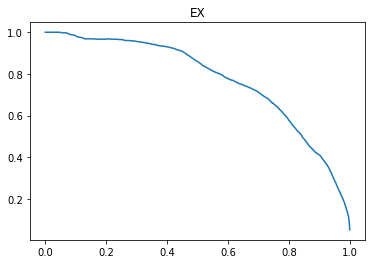

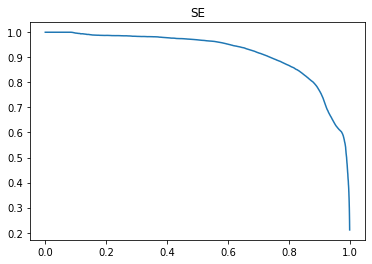

IDRiD_73
(4, 2922, 4368)


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3328: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


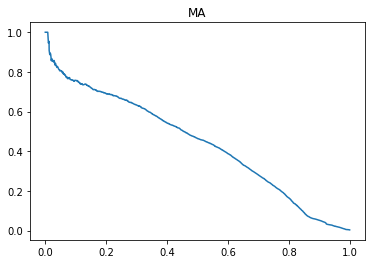

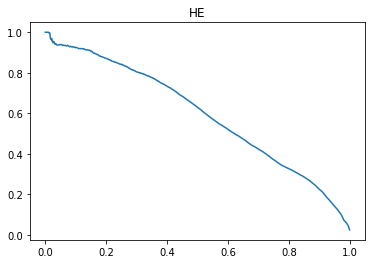

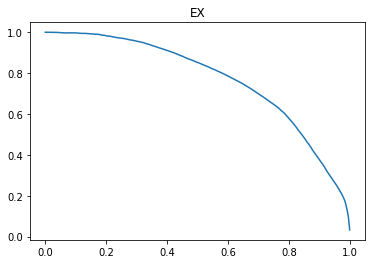

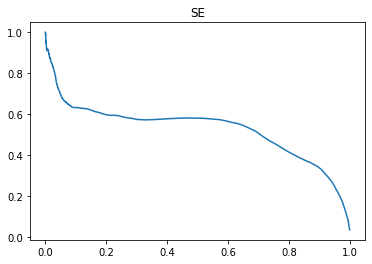

IDRiD_60
(4, 2922, 4368)


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3328: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


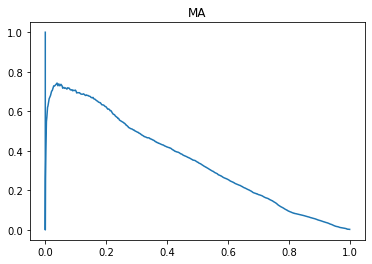

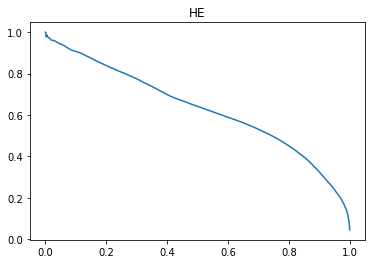

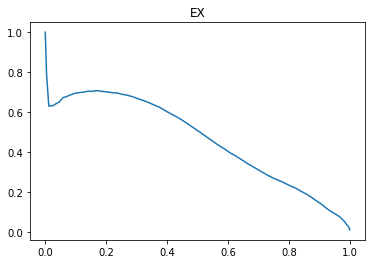

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:677: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


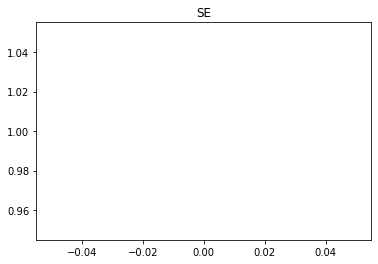

IDRiD_69
(4, 2922, 4368)


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3328: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


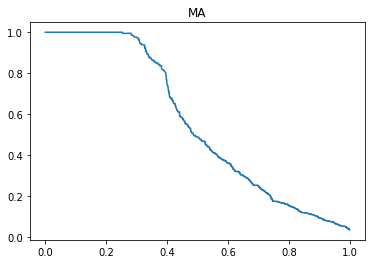

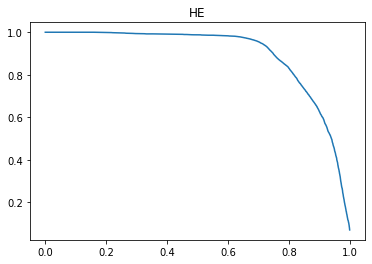

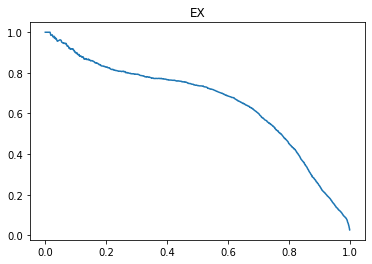

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:677: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


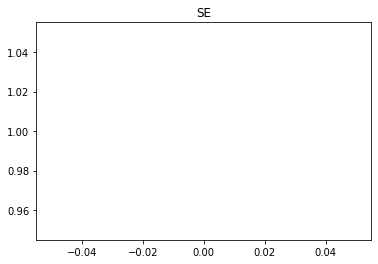

IDRiD_80
(4, 2922, 4368)


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3328: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


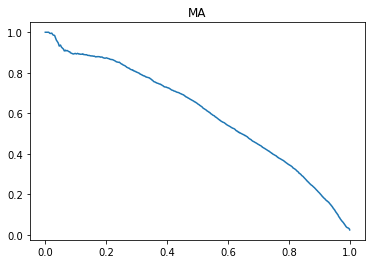

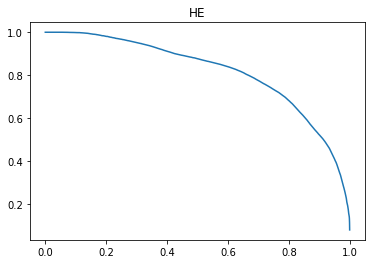

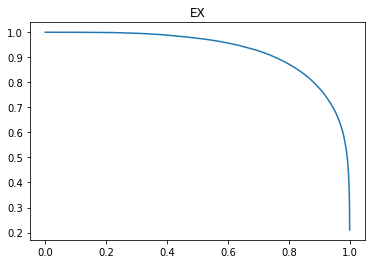

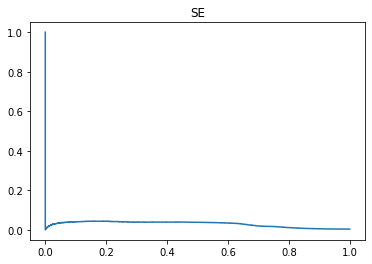

IDRiD_55
(4, 2922, 4368)


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3328: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


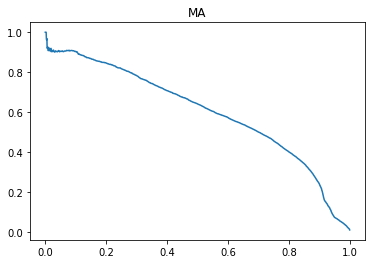

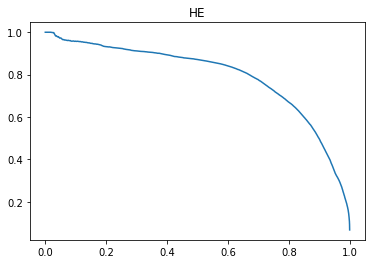

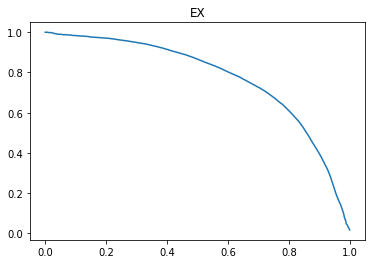

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:677: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


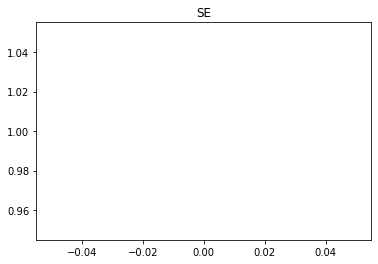

IDRiD_65
(4, 2922, 4368)


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3328: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


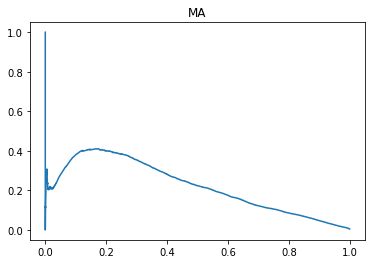

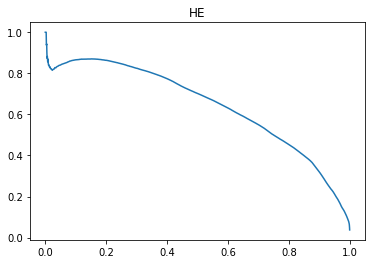

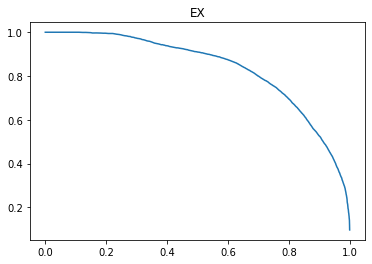

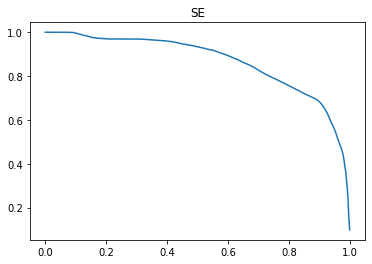

IDRiD_68
(4, 2922, 4368)


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3328: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


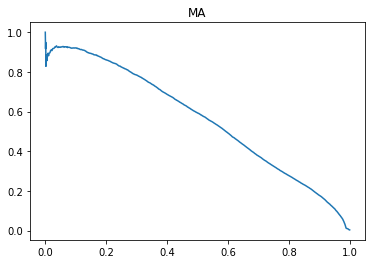

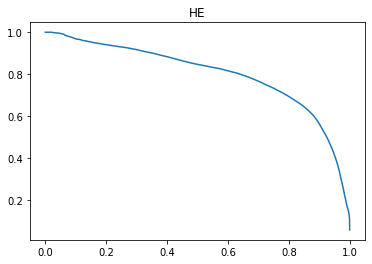

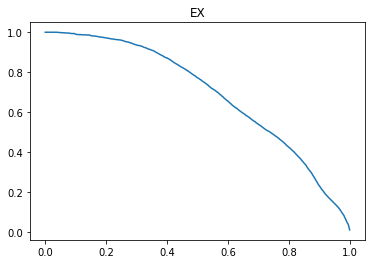

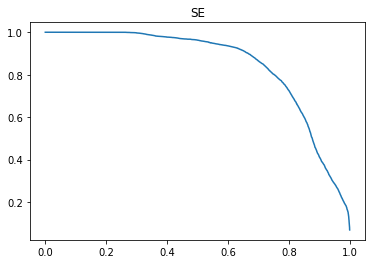

IDRiD_75
(4, 2922, 4368)


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3328: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


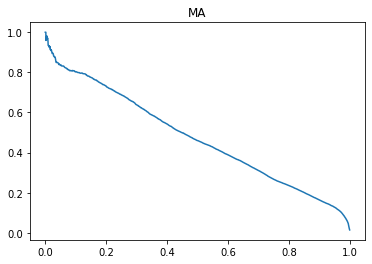

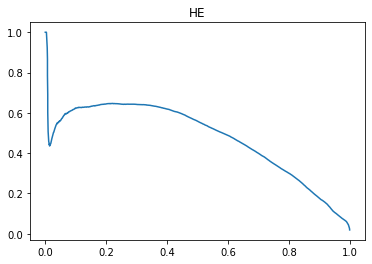

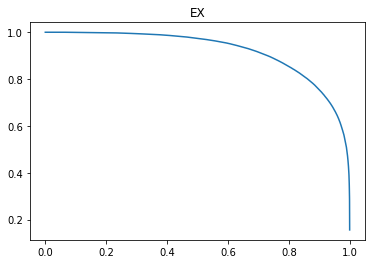

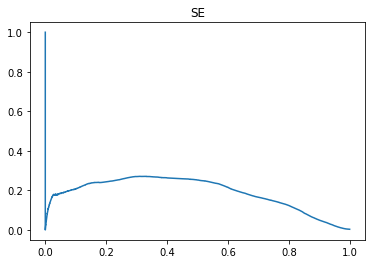

IDRiD_71
(4, 2922, 4368)


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3328: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


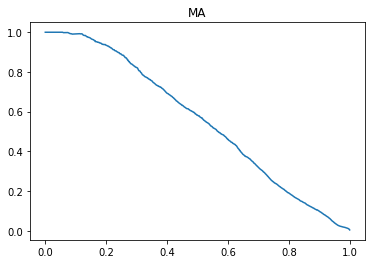

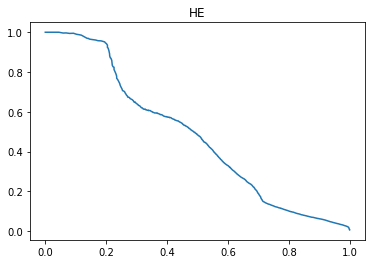

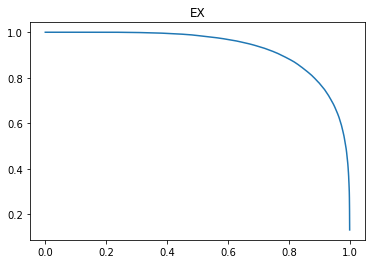

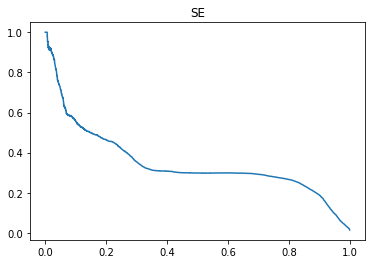

IDRiD_72
(4, 2922, 4368)


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3328: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


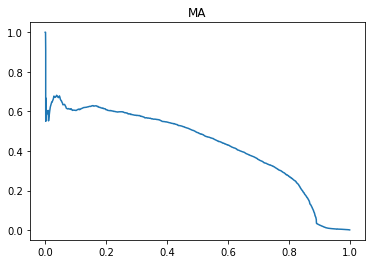

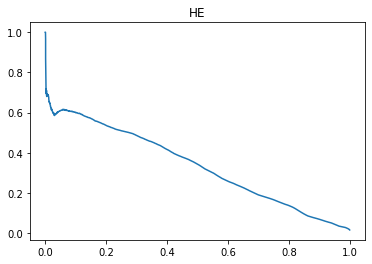

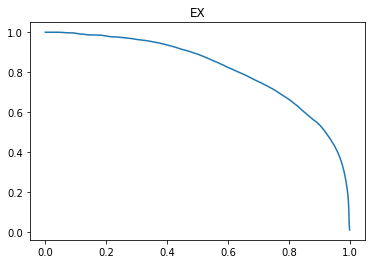

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:677: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


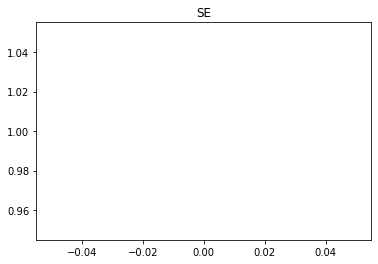

IDRiD_58
(4, 2922, 4368)


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3328: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


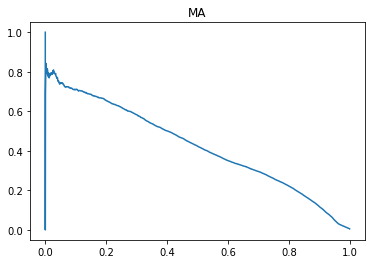

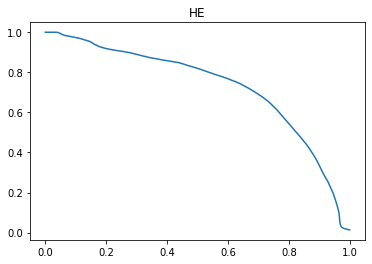

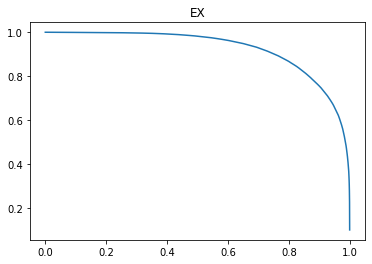

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:677: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


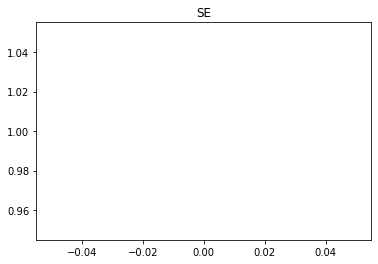

IDRiD_79
(4, 2922, 4368)


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3328: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


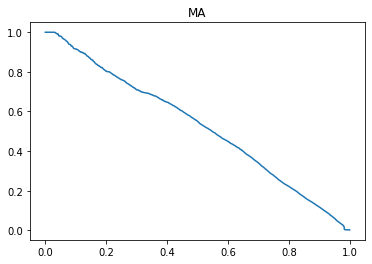

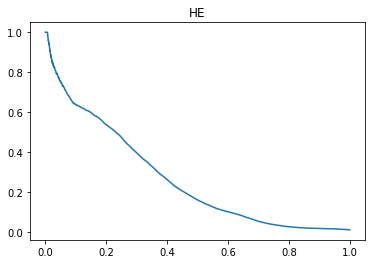

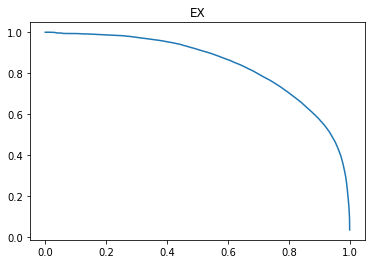

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:677: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


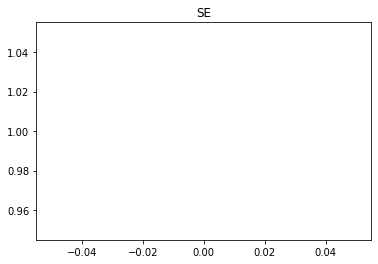

IDRiD_78
(4, 2922, 4368)


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3328: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


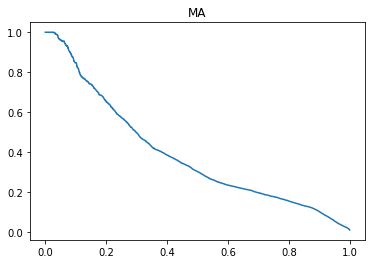

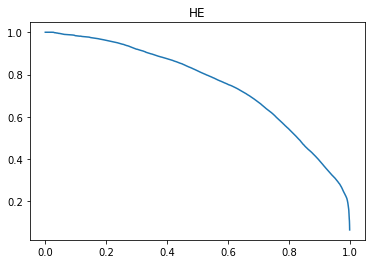

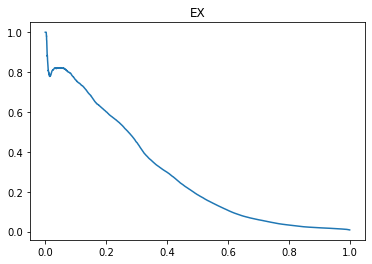

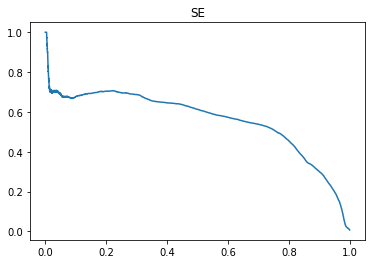

IDRiD_70
(4, 2922, 4368)


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3328: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


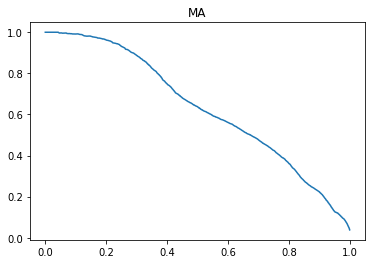

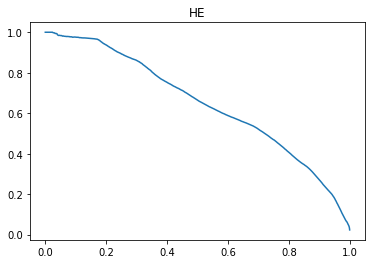

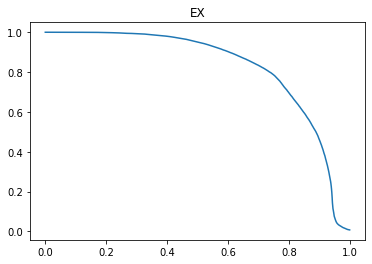

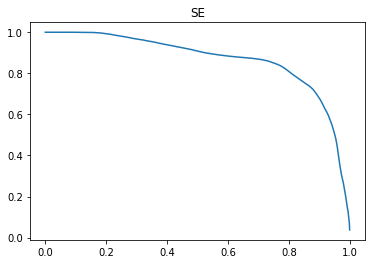

IDRiD_59
(4, 2922, 4368)


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3328: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


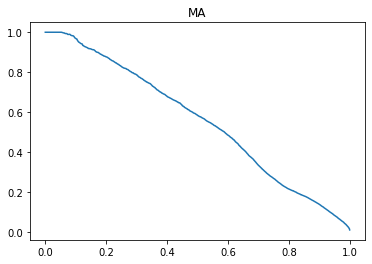

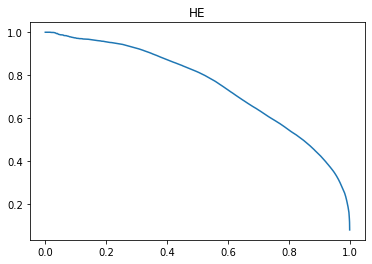

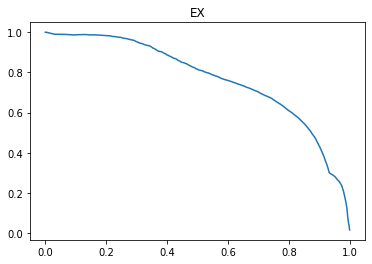

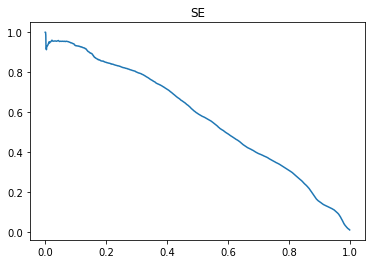

IDRiD_67
(4, 2922, 4368)


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3328: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


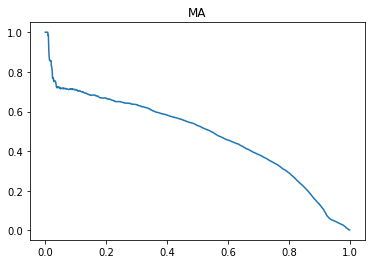

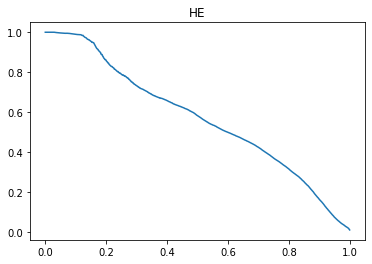

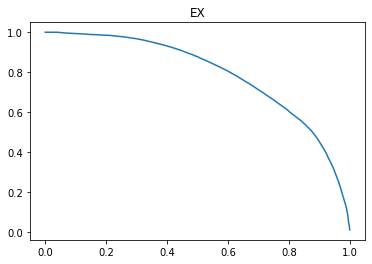

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:677: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


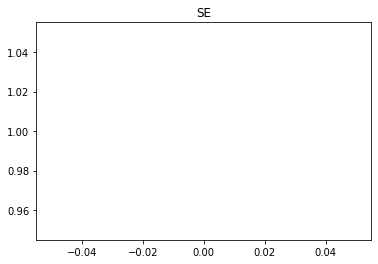

IDRiD_77
(4, 2922, 4368)


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3328: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


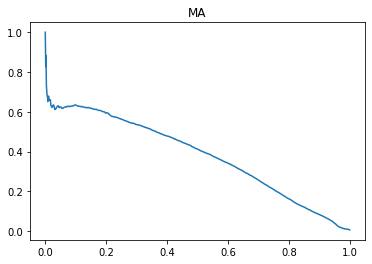

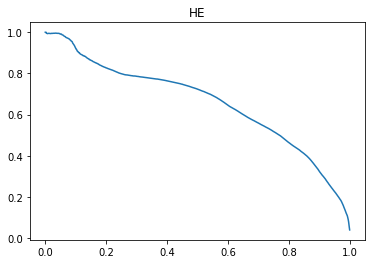

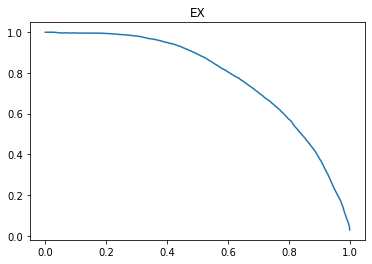

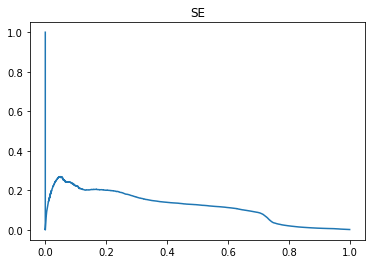

IDRiD_74
(4, 2922, 4368)


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3328: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


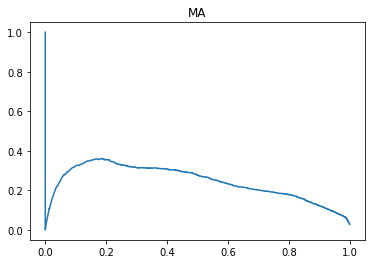

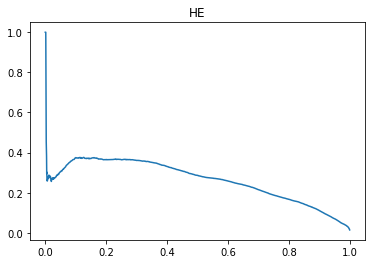

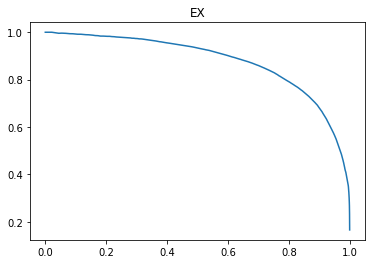

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:677: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


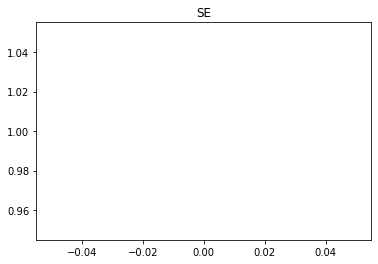

IDRiD_63
(4, 2922, 4368)


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3328: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


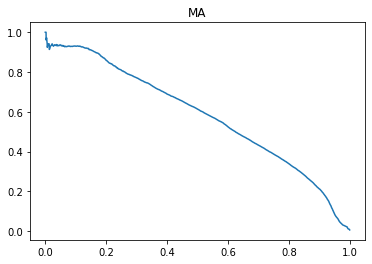

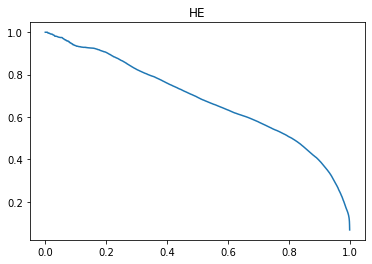

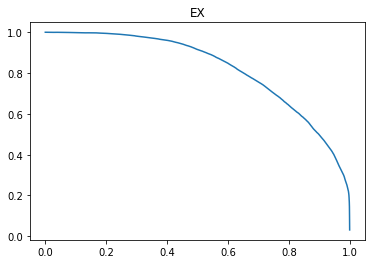

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:677: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


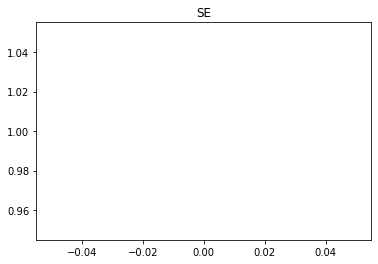

IDRiD_76
(4, 2922, 4368)


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3328: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


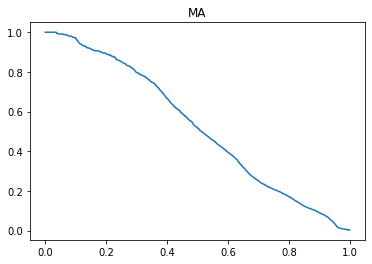

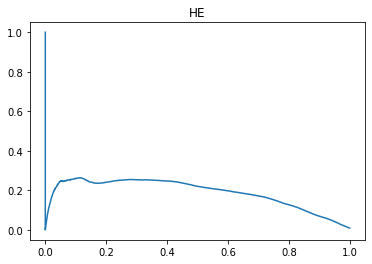

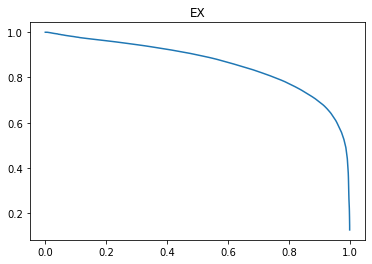

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:677: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


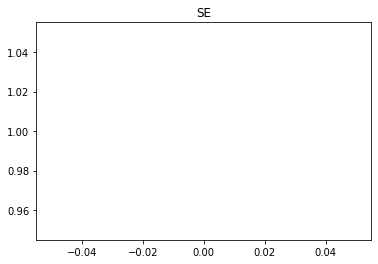

IDRiD_66
(4, 2922, 4368)


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3328: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


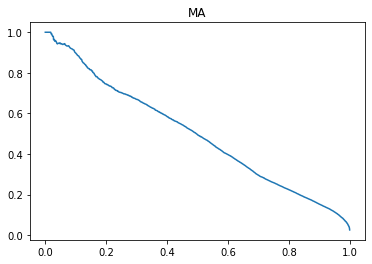

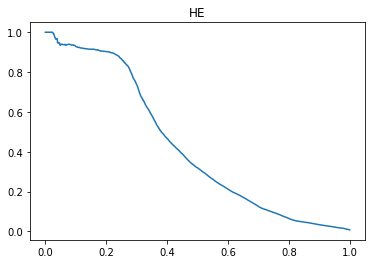

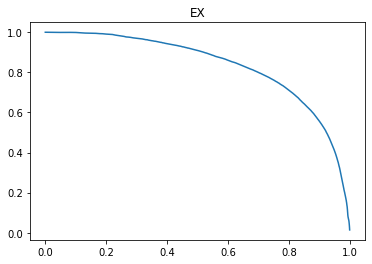

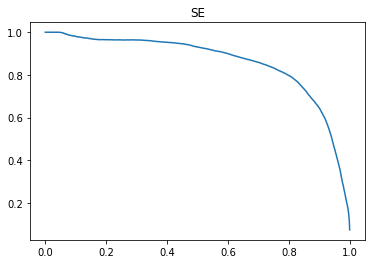

IDRiD_64


In [ ]:
auc_full_mask,auc_full_output=results_stadistics()

In [ ]:
#saving the valeus for calculating AUCPR in personal computer (metric.py)
with open('/gdrive/My Drive/data/auc_mask_4_train5_14epochs.npy', 'wb') as f:
    np.save(f, auc_full_mask)

In [ ]:
with open('/gdrive/My Drive/data/auc_output_4_train5_14epochs.npy', 'wb') as f:
    np.save(f, auc_full_output)

In [ ]:
# not run it here because it crash
# with open('/gdrive/My Drive/data/auc_mask_4_train5_14epochs.npy', 'rb') as f:
#     auc_full_mask = np.load(f)
# with open('/gdrive/My Drive/data/auc_output_4_train5_14epochs.npy', 'rb') as f:
#     auc_full_output = np.load(f)

In [ ]:
#calculate_plot_aucpr(auc_full_mask,auc_full_output)
# calculate_plot_aucpr_ind(auc_full_mask[:,0,:,:],auc_full_output[:,0,:,:],'MA')

(329730048,)
(329730048,)
